In [3]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
cu = pd.read_csv('EDA_customer.csv')
tr = pd.read_csv('EDA_transaction_last1.csv')
pr = pd.read_csv('EDA_product_last1.csv')

In [5]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254585 entries, 0 to 1254584
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   created_at           1254585 non-null  object 
 1   customer_id          1254585 non-null  int64  
 2   session_id           1254585 non-null  object 
 3   payment_method       1254585 non-null  object 
 4   payment_status       1254585 non-null  object 
 5   promo_amount         1254585 non-null  int64  
 6   promo_code           1254585 non-null  object 
 7   shipment_fee         1254585 non-null  int64  
 8   shipment_date_limit  1254585 non-null  object 
 9   total_amount         1254585 non-null  int64  
 10  product_id           1254585 non-null  int64  
 11  quantity             1254585 non-null  int64  
 12  item_price           1254585 non-null  int64  
 13  year                 1254585 non-null  int64  
 14  shipment_time        1254585 non-null  object 
 15

In [6]:
tr['session_id'].nunique()

852584

In [7]:
df = tr[['created_at','customer_id','session_id','payment_method','payment_status','promo_amount','promo_code','shipment_fee','product_id','quantity','item_price','buy_age']]

In [8]:
df= pd.merge(df, cu[['customer_id', 'first_join_date','gender','home_location']], on='customer_id', how='inner')

In [9]:
# 가격 컬럼, order_date컬럼 생성
df['price'] = df['item_price'] * df['quantity']

df['created_at'] = pd.to_datetime(df['created_at'])
df['order_date'] = df['created_at'].dt.date
df['order_time'] = df['created_at'].dt.time
df['order_time'] = df['order_time'].apply(lambda x: x.replace(microsecond=0))
df['order_time'] = pd.to_datetime(df['order_time'], format='%H:%M:%S')
df['order_hour'] = df['order_time'].dt.hour
df['order_time'] = pd.to_datetime(df['order_time'])
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_month'] = df['order_date'].dt.to_period('M')
# df['order_month'] = df['order_date'].dt.strftime('%Y-%m')
# df['order_month'] = pd.to_datetime(df['order_month'])
month_list = np.sort(df['order_month'].unique().tolist())
# df['order_year'] = df['order_date'].dt.year

In [10]:
df['first_join_date'] = pd.to_datetime(df['first_join_date'])

In [11]:
# 주문횟수 컬럼생성
df = df.sort_values(['customer_id', 'order_date'])
df['order_num'] = df.groupby('customer_id')['order_date'].rank(method='dense').astype(int)

In [12]:
# 주문주기 컬럼생성
df = df.sort_values(by=['customer_id', 'order_date'])
df['date_diff'] = df.groupby('customer_id')['order_date'].diff().dt.days
df['date_diff'] = df.groupby(['customer_id', 'order_date'])['date_diff'].transform('first')

In [13]:
# 결제성공, 7월이전 데이터 선택
df = df.query('payment_status == "Success"').reset_index(drop=True)
df = df[df['order_date']< "2022-07-01"]

In [14]:
df.head()

created_at  customer_id  \
0 2018-08-25 18:54:03.844494+00:00            3   
1 2018-09-22 18:42:52.844494+00:00            3   
2 2018-10-20 19:07:54.844494+00:00            3   
3 2018-11-17 19:09:49.844494+00:00            3   
4 2018-12-15 19:33:50.844494+00:00            3   

                             session_id payment_method payment_status  \
0  f03b6825-1e6e-4916-bf71-f94ecbcbaee5    Credit Card        Success   
1  36673b2f-940a-42b5-994d-1cce4796b55f    Credit Card        Success   
2  93e1d3c4-bed1-4ef4-b79f-e24a79e905b7    Credit Card        Success   
3  8356370c-267e-4530-a2d3-1830e4be3f2b    Credit Card        Success   
4  ef7f4829-e7d1-4513-861b-1fbbc6e41bbf    Credit Card        Success   

   promo_amount     promo_code  shipment_fee  product_id  quantity  ...  \
0          8073  WEEKENDMANTAP             0       56019         5  ...   
1             0   Not Promoted         10000       30235         1  ...   
2          8828    WEEKENDSERU         10000        7808         1  ...   
3          3415    WEEKENDSERU             0       48968         1  ...   
4          2645      LIBURDONG         10000       59272         1  ...   

   first_join_date  gender home_location   price order_date  \
0       2018-08-25       M  Jakarta Raya  834670 2018-08-25   
1       2018-08-25       M  Jakarta Raya  153784 2018-09-22   
2       2018-08-25       M  Jakarta Raya  123760 2018-10-20   
3       2018-08-25       M  Jakarta Raya  251317 2018-11-17   
4       2018-08-25       M  Jakarta Raya  173882 2018-12-15   

           order_time order_hour order_month  order_num date_diff  
0 1900-01-01 18:54:03         18     2018-08          1       NaN  
1 1900-01-01 18:42:52         18     2018-09          2      28.0  
2 1900-01-01 19:07:54         19     2018-10          3      28.0  
3 1900-01-01 19:09:49         19     2018-11          4      28.0  
4 1900-01-01 19:33:50         19     2018-12          5      28.0  

[5 rows x 22 columns]

### 7월전까지 거래 데이터 사용

가입기간(Duration)

In [15]:
last_transaction_date = df['order_date'].max() 
df['membership_duration'] = (last_transaction_date - df['first_join_date']).dt.days

In [16]:
rfm_d = df.groupby('customer_id', as_index=False)['membership_duration'].min()
rfm_d

customer_id  membership_duration
0                3                 1405
1                8                  502
2                9                  369
3               11                  116
4               15                 1006
...            ...                  ...
49239        99992                  730
49240        99995                  683
49241        99997                  796
49242        99998                 1460
49243        99999                 2087

[49244 rows x 2 columns]

In [17]:
rfm_d.describe()

customer_id  membership_duration
count  49244.000000         49244.000000
mean   49800.257717           970.617476
std    28952.498516           610.773241
min        3.000000             0.000000
25%    24703.500000           431.000000
50%    49724.000000           908.000000
75%    74845.500000          1459.000000
max    99999.000000          2191.000000

In [18]:
#2달 이상 이용한 고객만 선택 (이상치 제거)
rfm_d = rfm_d.query('membership_duration >= 60')

Recency

In [19]:
rfm_r = df.groupby('customer_id', as_index=False)['created_at'].max()
rfm_r['created_at'] = rfm_r['created_at'].apply(lambda x: str(x)[:10])
rfm_r['created_at'] = pd.to_datetime(rfm_r['created_at'])
rfm_r.rename(columns={'created_at':'last_transaction_date'}, inplace=True)
rfm_r

customer_id last_transaction_date
0                3            2022-06-26
1                8            2022-05-15
2                9            2022-05-28
3               11            2022-03-07
4               15            2022-01-05
...            ...                   ...
49239        99992            2022-05-25
49240        99995            2022-06-23
49241        99997            2020-04-25
49242        99998            2022-01-25
49243        99999            2016-10-12

[49244 rows x 2 columns]

In [20]:
rfm_r['DateDiff'] = max(rfm_r['last_transaction_date']) - rfm_r['last_transaction_date']
rfm_r.drop(['last_transaction_date'], axis=1, inplace=True)
rfm_r

customer_id  DateDiff
0                3    4 days
1                8   46 days
2                9   33 days
3               11  115 days
4               15  176 days
...            ...       ...
49239        99992   36 days
49240        99995    7 days
49241        99997  796 days
49242        99998  156 days
49243        99999 2087 days

[49244 rows x 2 columns]

In [21]:
rfm_r['DateDiff'] = rfm_r['DateDiff'].astype(str)
rfm_r['DateDiff'] = rfm_r['DateDiff'].apply(lambda x: str(x)[:-5]).astype(int)
rfm_r

customer_id  DateDiff
0                3         4
1                8        46
2                9        33
3               11       115
4               15       176
...            ...       ...
49239        99992        36
49240        99995         7
49241        99997       796
49242        99998       156
49243        99999      2087

[49244 rows x 2 columns]

In [22]:
rfm_r.describe()

customer_id      DateDiff
count  49244.000000  49244.000000
mean   49800.257717    279.575847
std    28952.498516    433.563896
min        3.000000      0.000000
25%    24703.500000     19.000000
50%    49724.000000     86.000000
75%    74845.500000    336.000000
max    99999.000000   2190.000000

In [23]:
#2년 이내에 구매가 이루어진 고객만 선택 (이상치 제거)
rfm_r = rfm_r.query('DateDiff <= 730')

Frequency

In [24]:
rfm_f = (df.drop_duplicates(['created_at'])).groupby('customer_id', as_index=False)['created_at'].count()
rfm_f.rename(columns={'created_at':'transaction_count'}, inplace=True)
rfm_f

customer_id  transaction_count
0                3                 49
1                8                  7
2                9                  6
3               11                  1
4               15                  5
...            ...                ...
49239        99992                 12
49240        99995                 56
49241        99997                  1
49242        99998                  8
49243        99999                  1

[49244 rows x 2 columns]

In [25]:
rfm_f.describe()

customer_id  transaction_count
count  49244.000000       49244.000000
mean   49800.257717          16.080619
std    28952.498516          28.483204
min        3.000000           1.000000
25%    24703.500000           2.000000
50%    49724.000000           6.000000
75%    74845.500000          17.000000
max    99999.000000         542.000000

In [26]:
#  한달에  1번씩 거래한 고객까지 선택 (이상치 제거)
rfm_f = rfm_f.query('transaction_count  <= 72')

Monetary

In [27]:
# 고객별 총 구매 금액 (Monetary)
rfm_m = df.groupby('customer_id', as_index=False)['price'].sum()
rfm_m.rename(columns={'price':'total_price'}, inplace=True)
rfm_m

customer_id  total_price
0                3     20676434
1                8      3861260
2                9      2603665
3               11       192025
4               15      2101232
...            ...          ...
49239        99992      4234671
49240        99995     29908623
49241        99997       216461
49242        99998      6667865
49243        99999       186111

[49244 rows x 2 columns]

In [28]:
rfm_m.describe()

customer_id   total_price
count  49244.000000  4.924400e+04
mean   49800.257717  8.733122e+06
std    28952.498516  1.579185e+07
min        3.000000  2.454600e+04
25%    24703.500000  7.457988e+05
50%    49724.000000  2.907819e+06
75%    74845.500000  9.597000e+06
max    99999.000000  3.108488e+08

In [29]:
#  이하로 구매한 고객 선택 (이상치 제거)
rfm_m = rfm_m.query('total_price  <= 40000000')

### RFM 생성

In [30]:
rfm_d = rfm_d.set_index('customer_id')
rfm_r = rfm_r.set_index('customer_id')
rfm_f = rfm_f.set_index('customer_id')
rfm_m = rfm_m.set_index('customer_id')

rfm = rfm_d.join([rfm_r,rfm_f, rfm_m], how='inner')
rfm.columns = ['Duration','Recency','Frequency','Monetary']
rfm

Duration  Recency  Frequency  Monetary
customer_id                                        
3                1405        4         49  20676434
8                 502       46          7   3861260
9                 369       33          6   2603665
11                116      115          1    192025
15               1006      176          5   2101232
...               ...      ...        ...       ...
99989             452       88          4   2539075
99991             495      319          2    623429
99992             730       36         12   4234671
99995             683        7         56  29908623
99998            1460      156          8   6667865

[39795 rows x 4 columns]

In [31]:
rfm.describe()

Duration       Recency     Frequency      Monetary
count  39795.000000  39795.000000  39795.000000  3.979500e+04
mean     894.408393    152.870738     12.692097  6.825046e+06
std      585.905457    180.444973     14.393207  8.066547e+06
min       60.000000      0.000000      1.000000  2.745000e+04
25%      366.500000     20.000000      3.000000  1.136580e+06
50%      751.000000     74.000000      7.000000  3.533767e+06
75%     1362.000000    226.000000     17.000000  9.465506e+06
max     2191.000000    730.000000     72.000000  3.999056e+07

### Log Transformation

duration

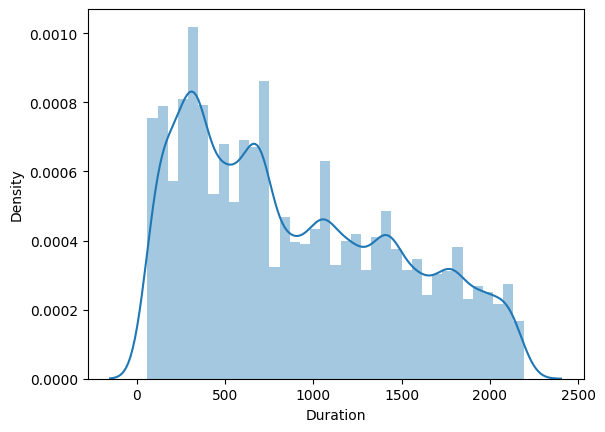

In [32]:
sns.distplot(rfm["Duration"]);

<Axes: xlabel='Duration', ylabel='Density'>

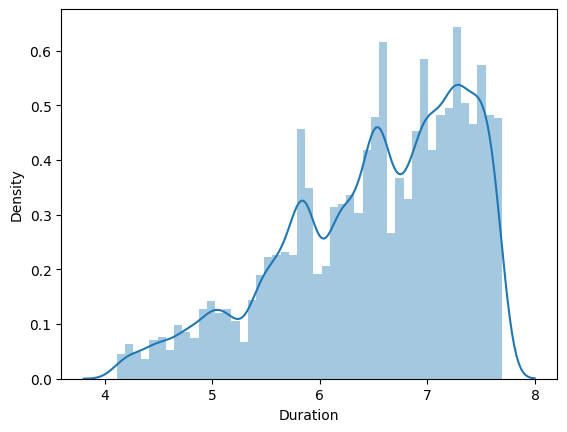

In [33]:
duration_log = np.log1p(rfm['Duration'])
sns.distplot(duration_log)

recency

<Axes: xlabel='Recency', ylabel='Density'>

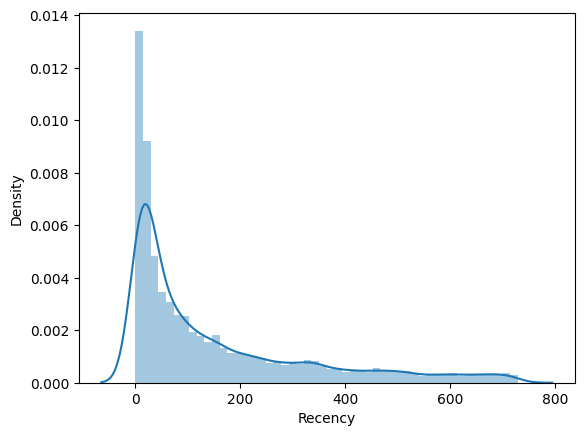

In [34]:
sns.distplot(rfm["Recency"])

<Axes: xlabel='Recency', ylabel='Density'>

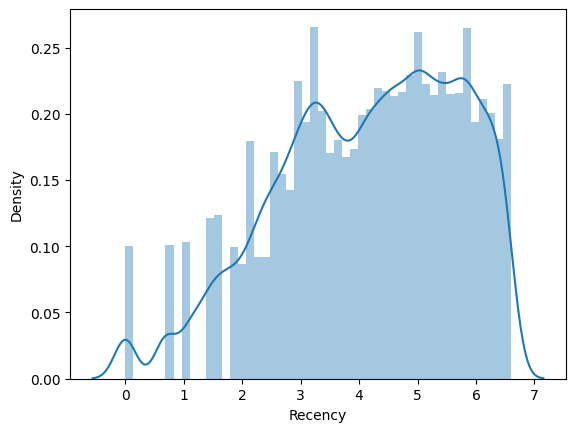

In [35]:
recency_log = np.log1p(rfm['Recency'])
sns.distplot(recency_log)

frequency

<Axes: xlabel='Frequency', ylabel='Density'>

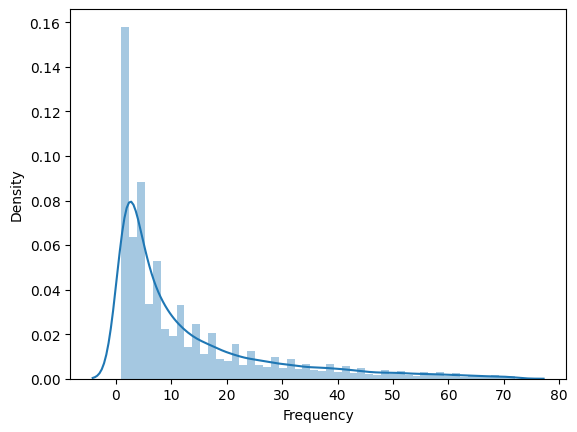

In [36]:
sns.distplot(rfm["Frequency"])

<Axes: xlabel='Frequency', ylabel='Density'>

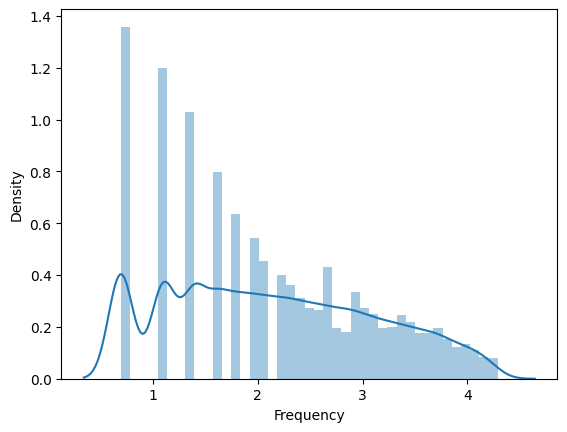

In [37]:
frequency_log = np.log1p(rfm['Frequency'])
sns.distplot(frequency_log)

monetary

<Axes: xlabel='Monetary', ylabel='Density'>

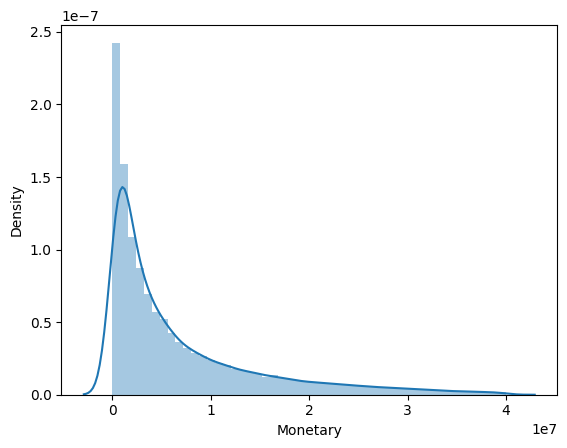

In [38]:
sns.distplot(rfm["Monetary"])


<Axes: xlabel='Monetary', ylabel='Density'>

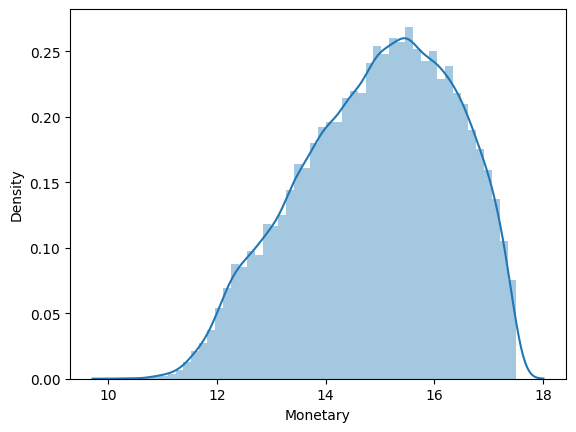

In [39]:
monetary_log = np.log1p(rfm['Monetary'])
sns.distplot(monetary_log)

Data Scaling

In [40]:
log_rfm = pd.concat([duration_log,recency_log, frequency_log, monetary_log], axis=1)
log_rfm

Duration   Recency  Frequency   Monetary
customer_id                                          
3            7.248504  1.609438   3.912023  16.844505
8            6.220590  3.850148   2.079442  15.166504
9            5.913503  3.526361   1.945910  14.772431
11           4.762174  4.753590   0.693147  12.165386
15           6.914731  5.176150   1.791759  14.558035
...               ...       ...        ...        ...
99989        6.115892  4.488636   1.609438  14.747311
99991        6.206576  5.768321   1.098612  13.342992
99992        6.594413  3.610918   2.564949  15.258816
99995        6.527958  2.079442   4.043051  17.213657
99998        7.286876  5.056246   2.197225  15.712810

[39795 rows x 4 columns]

In [41]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(log_rfm)

### clustering

In [42]:
sse = {}  # sse : elbow method에서 SSE(군집 내 거리의 제곱합)를 기준으로 SSE가 급격하게 낮아지는 지점을 군집의 개수 K로 지정

for k in range(1,10):
  kmeans = KMeans(n_clusters=k, random_state=1)
  kmeans.fit(rfm_scaled)
  sse[k] = kmeans.inertia_

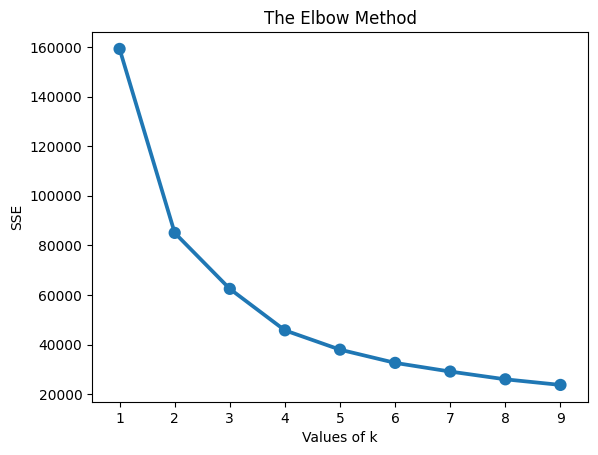

In [43]:
# 결과 시각화
plt.title('The Elbow Method')
plt.xlabel('Values of k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### 3clusters

In [44]:
# 최종 모델 학습
kmeans = KMeans(n_clusters=3, max_iter=50, random_state=42)
kmeans.fit(rfm_scaled)

# 고객별 클러스터 지정
cluster_labels = kmeans.labels_

rfm_k3 = rfm.assign(Cluster = cluster_labels)

In [45]:
rfm_k3.head()

Duration  Recency  Frequency  Monetary  Cluster
customer_id                                                 
3                1405        4         49  20676434        0
8                 502       46          7   3861260        1
9                 369       33          6   2603665        2
11                116      115          1    192025        2
15               1006      176          5   2101232        1

In [46]:
cluster_0 = rfm_k3[rfm_k3.Cluster == 0]
cluster_1 = rfm_k3[rfm_k3.Cluster == 1]
cluster_2 = rfm_k3[rfm_k3.Cluster == 2]

In [47]:
cluster_avg = rfm_k3.groupby(['Cluster']).mean()
cluster_avg

Duration     Recency  Frequency      Monetary
Cluster                                                  
0         953.610567   21.642046  25.909781  1.408308e+07
1        1256.048215  258.705455   5.822323  3.116260e+06
2         328.503431  205.402307   2.381148  1.079022e+06

In [48]:
population_avg = rfm.mean()
population_avg

Duration     8.944084e+02
Recency      1.528707e+02
Frequency    1.269210e+01
Monetary     6.825046e+06
dtype: float64

In [49]:
relative_imp = cluster_avg / population_avg - 1

In [50]:
relative_imp.round(2)

Duration  Recency  Frequency  Monetary
Cluster                                        
0            0.07    -0.86       1.04      1.06
1            0.40     0.69      -0.54     -0.54
2           -0.63     0.34      -0.81     -0.84

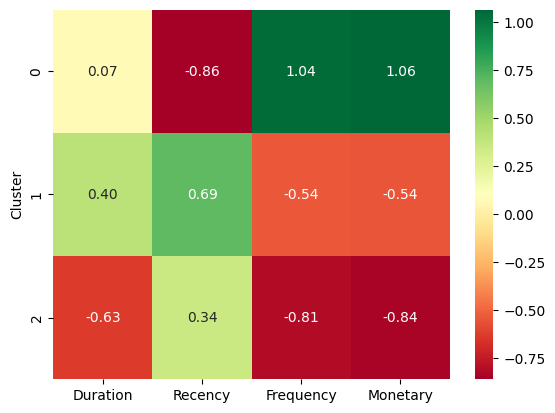

In [51]:
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap = "RdYlGn");

### 4clusters

In [52]:
kmeans = KMeans(n_clusters=4, max_iter=50, random_state=42)
kmeans.fit(rfm_scaled)

# 고객별 클러스터 지정
cluster_labels = kmeans.labels_

rfm_k4 = rfm.assign(Cluster = cluster_labels)

In [53]:
rfm_k4.head()

Duration  Recency  Frequency  Monetary  Cluster
customer_id                                                 
3                1405        4         49  20676434        2
8                 502       46          7   3861260        0
9                 369       33          6   2603665        0
11                116      115          1    192025        3
15               1006      176          5   2101232        1

In [54]:
cluster_40 = rfm_k4[rfm_k4.Cluster == 0]
cluster_41 = rfm_k4[rfm_k4.Cluster == 1]
cluster_42 = rfm_k4[rfm_k4.Cluster == 2]
cluster_43 = rfm_k4[rfm_k4.Cluster == 3]

In [55]:
cluster_avg4 = rfm_k4.groupby(['Cluster']).mean()
cluster_avg4

Duration     Recency  Frequency      Monetary
Cluster                                                  
0         263.754235   18.635661   9.467311  5.134727e+06
1        1266.583263  244.758411   6.000616  3.222499e+06
2        1185.904337   25.507402  30.266124  1.642301e+07
3         430.250440  291.409971   1.621232  6.436044e+05

In [56]:
population_avg4 = rfm.mean()
population_avg4

Duration     8.944084e+02
Recency      1.528707e+02
Frequency    1.269210e+01
Monetary     6.825046e+06
dtype: float64

In [57]:
relative_imp4 = cluster_avg4 / population_avg4 - 1

In [58]:
relative_imp4.round(2)

Duration  Recency  Frequency  Monetary
Cluster                                        
0           -0.71    -0.88      -0.25     -0.25
1            0.42     0.60      -0.53     -0.53
2            0.33    -0.83       1.38      1.41
3           -0.52     0.91      -0.87     -0.91

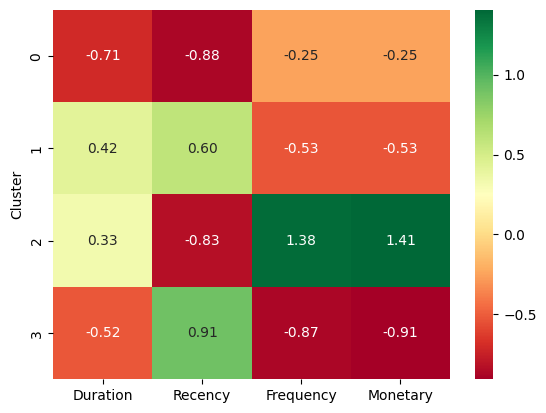

In [59]:
sns.heatmap(data=relative_imp4, annot=True, fmt='.2f', cmap = "RdYlGn");

### 클러스터 특징확인

In [60]:
cluster_summary = rfm_k4.groupby('Cluster').agg({
    'Duration': ['min', 'max', 'mean'],
    'Recency': ['min', 'max', 'mean'],
    'Frequency': ['min', 'max', 'mean'],
    'Monetary': ['min', 'max', 'mean']
}).reset_index()

print(cluster_summary)

  Cluster Duration                    Recency                  Frequency      \
               min   max         mean     min  max        mean       min max   
0       0       60   719   263.754235       0  132   18.635661         1  68   
1       1      333  2191  1266.583263      26  730  244.758411         1  23   
2       2      180  2189  1185.904337       0  189   25.507402         8  72   
3       3       60  1776   430.250440      12  730  291.409971         1   6   

             Monetary                          
        mean      min       max          mean  
0   9.467311   280611  37857135  5.134727e+06  
1   6.000616   244403  20931974  3.222499e+06  
2  30.266124  2804923  39990565  1.642301e+07  
3   1.621232    27450   7910114  6.436044e+05  


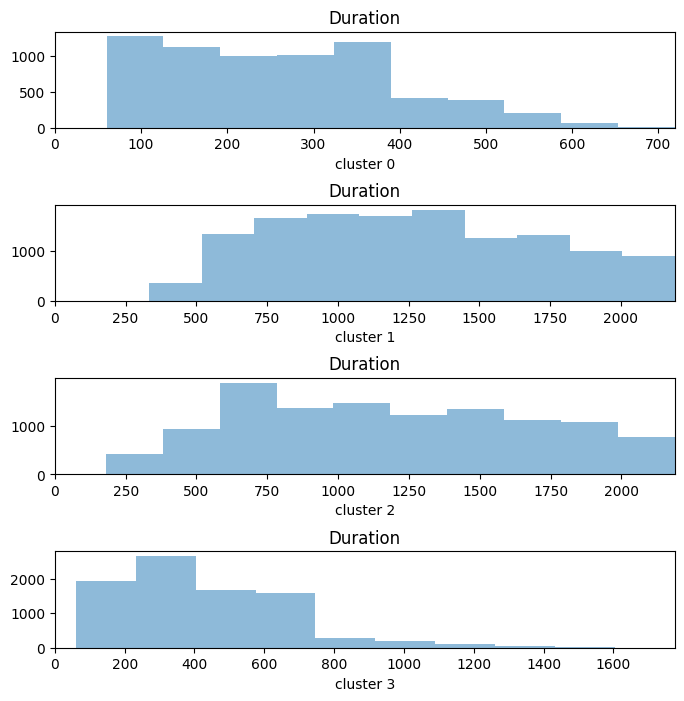

In [61]:
var = [cluster_40.Duration, cluster_41.Duration, cluster_42.Duration,cluster_43.Duration]
cluster = ['cluster 0', 'cluster 1', 'cluster 2','cluster 3']

fig, ax = plt.subplots(4,1, figsize=[8,8])

for i in range(len(var)):
  variable= var[i]
  ax[i].hist(variable, alpha=0.5)
  ax[i].set_xlim(0, var[i].max())
  ax[i].set_xlabel(f'{cluster[i]}')
  ax[i].set_title('Duration')

plt.subplots_adjust(hspace=0.8)

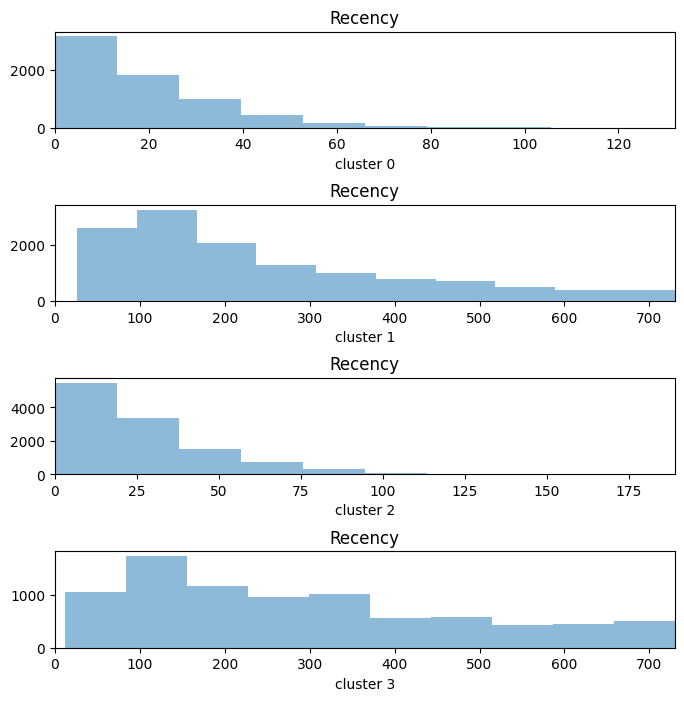

In [62]:
var = [cluster_40.Recency, cluster_41.Recency, cluster_42.Recency,cluster_43.Recency]
cluster = ['cluster 0', 'cluster 1', 'cluster 2','cluster 3']

fig, ax = plt.subplots(4,1, figsize=[8,8])

for i in range(len(var)):
  variable= var[i]
  ax[i].hist(variable, alpha=0.5)
  ax[i].set_xlim(0, var[i].max())
  ax[i].set_xlabel(f'{cluster[i]}')
  ax[i].set_title('Recency')

plt.subplots_adjust(hspace=0.8)

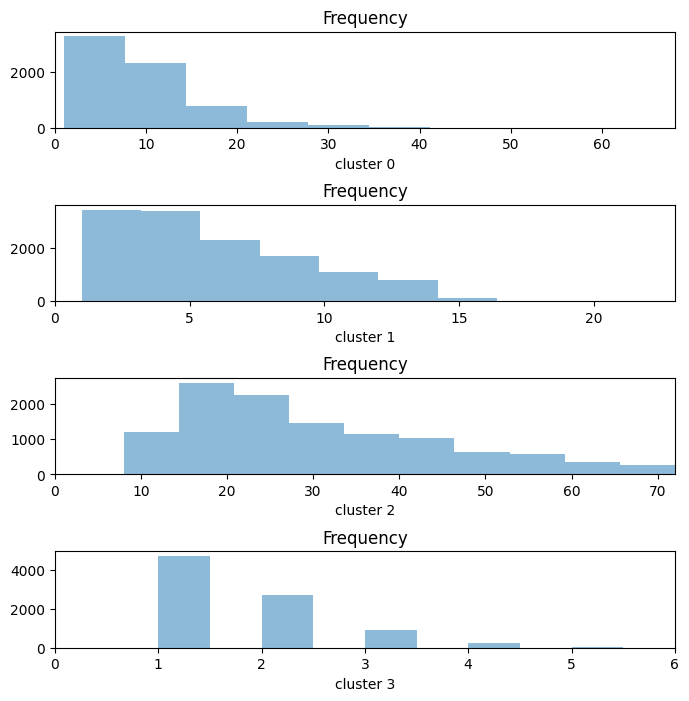

In [63]:
var = [cluster_40.Frequency, cluster_41.Frequency, cluster_42.Frequency,cluster_43.Frequency]
cluster = ['cluster 0', 'cluster 1', 'cluster 2','cluster 3']

fig, ax = plt.subplots(4,1, figsize=[8,8])

for i in range(len(var)):
  variable= var[i]
  ax[i].hist(variable, alpha=0.5)
  ax[i].set_xlim(0, var[i].max())
  ax[i].set_xlabel(f'{cluster[i]}')
  ax[i].set_title('Frequency')

plt.subplots_adjust(hspace=0.8)

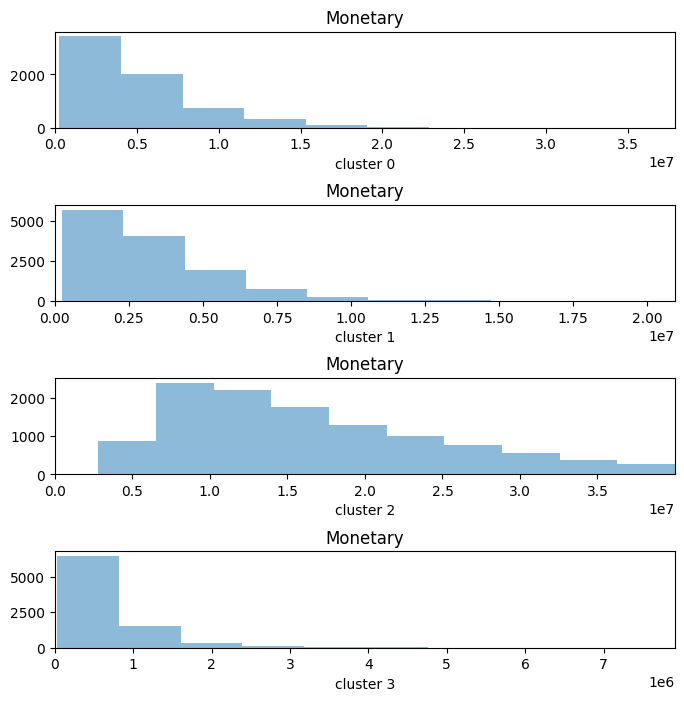

In [64]:
var = [cluster_40.Monetary, cluster_41.Monetary, cluster_42.Monetary,cluster_43.Monetary]
cluster = ['cluster 0', 'cluster 1', 'cluster 2','cluster 3']

fig, ax = plt.subplots(4,1, figsize=[8,8])

for i in range(len(var)):
  variable= var[i]
  ax[i].hist(variable, alpha=0.5)
  ax[i].set_xlim(0, var[i].max())
  ax[i].set_xlabel(f'{cluster[i]}')
  ax[i].set_title('Monetary')

plt.subplots_adjust(hspace=0.8)

### 세부분석

- 어떤 물품 구매했는지
- 인적특성?
- 주기특성?
- 무료배송?
- 프로모션?

In [65]:
target= pd.merge(df, rfm_k4, on='customer_id', how='inner')
target.head()

created_at  customer_id  \
0 2018-08-25 18:54:03.844494+00:00            3   
1 2018-09-22 18:42:52.844494+00:00            3   
2 2018-10-20 19:07:54.844494+00:00            3   
3 2018-11-17 19:09:49.844494+00:00            3   
4 2018-12-15 19:33:50.844494+00:00            3   

                             session_id payment_method payment_status  \
0  f03b6825-1e6e-4916-bf71-f94ecbcbaee5    Credit Card        Success   
1  36673b2f-940a-42b5-994d-1cce4796b55f    Credit Card        Success   
2  93e1d3c4-bed1-4ef4-b79f-e24a79e905b7    Credit Card        Success   
3  8356370c-267e-4530-a2d3-1830e4be3f2b    Credit Card        Success   
4  ef7f4829-e7d1-4513-861b-1fbbc6e41bbf    Credit Card        Success   

   promo_amount     promo_code  shipment_fee  product_id  quantity  ...  \
0          8073  WEEKENDMANTAP             0       56019         5  ...   
1             0   Not Promoted         10000       30235         1  ...   
2          8828    WEEKENDSERU         10000        7808         1  ...   
3          3415    WEEKENDSERU             0       48968         1  ...   
4          2645      LIBURDONG         10000       59272         1  ...   

   order_hour  order_month order_num date_diff membership_duration  Duration  \
0          18      2018-08         1       NaN                1405      1405   
1          18      2018-09         2      28.0                1405      1405   
2          19      2018-10         3      28.0                1405      1405   
3          19      2018-11         4      28.0                1405      1405   
4          19      2018-12         5      28.0                1405      1405   

  Recency Frequency  Monetary Cluster  
0       4        49  20676434       2  
1       4        49  20676434       2  
2       4        49  20676434       2  
3       4        49  20676434       2  
4       4        49  20676434       2  

[5 rows x 28 columns]

In [66]:
pr_join=pr[['product_id','season','usage','masterCategory','subCategory','articleType',]]

In [67]:
target= pd.merge(target, pr_join, on='product_id', how='inner')

In [68]:
target['customer_id'].nunique()

39795

In [69]:
target.groupby('Cluster')['customer_id'].nunique()

Cluster
0     6730
1    12989
2    11551
3     8525
Name: customer_id, dtype: int64

In [70]:
# def categorize_customer(row):
#     time_difference = row['order_date'] - row['first_join_date']
#     if time_difference.days <= 60:
#         return '신규고객'
#     else:
#         return '기존고객'

# target['customer_category'] = target.apply(categorize_customer, axis=1)
# target.head()

In [71]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740041 entries, 0 to 740040
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   created_at           740041 non-null  datetime64[ns, UTC]
 1   customer_id          740041 non-null  int64              
 2   session_id           740041 non-null  object             
 3   payment_method       740041 non-null  object             
 4   payment_status       740041 non-null  object             
 5   promo_amount         740041 non-null  int64              
 6   promo_code           740041 non-null  object             
 7   shipment_fee         740041 non-null  int64              
 8   product_id           740041 non-null  int64              
 9   quantity             740041 non-null  int64              
 10  item_price           740041 non-null  int64              
 11  buy_age              740041 non-null  int64              
 12  fi

In [72]:
cluster_0 = target[target.Cluster == 0]
cluster_1 = target[target.Cluster == 1]
cluster_2 = target[target.Cluster == 2]
cluster_3 = target[target.Cluster == 3]

print(cluster_0.shape[0])
print(cluster_1.shape[0])
print(cluster_2.shape[0])
print(cluster_3.shape[0])

93605
113924
515032
17480


In [73]:
# csv = target[['customer_id','session_id','Cluster','order_num','date_diff','first_join_date']]
# csv.to_csv("customer_cluster.csv", index=False, encoding="utf-8-sig", mode="w")

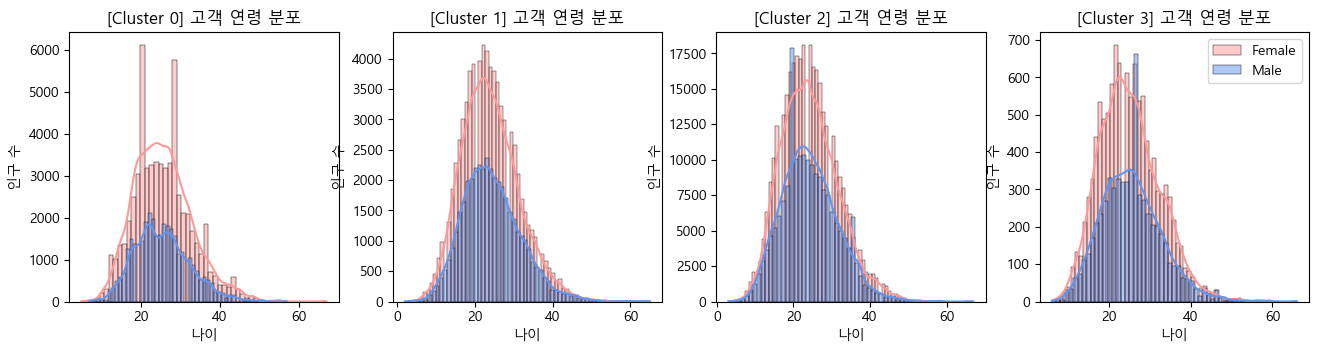

In [74]:
# 성별/나이에 따른 히스토그램 (사용자 분포 확인)
cluster_0_female = cluster_0.query('gender == "F"')
cluster_0_male = cluster_0.query('gender == "M"')
cluster_1_female = cluster_1.query('gender == "F"')
cluster_1_male = cluster_1.query('gender == "M"')
cluster_2_female = cluster_2.query('gender == "F"')
cluster_2_male = cluster_2.query('gender == "M"')
cluster_3_female = cluster_3.query('gender == "F"')
cluster_3_male = cluster_3.query('gender == "M"')

fig = plt.figure(figsize=(16, 3.5))
grid = GridSpec(1, 4)  # 1행 4열의 그리드 생성, 각 열의 비율 조정

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.subplot(grid[0])
sns.histplot(data=cluster_0_female, x='buy_age', bins=len(cluster_0['buy_age'].unique()), color='#ff9999', kde=True, label='Female')
sns.histplot(data=cluster_0_male, x='buy_age', bins=len(cluster_0['buy_age'].unique()), color='cornflowerblue', kde=True, label='Male')
plt.xlabel('나이')
plt.ylabel('인구 수')
plt.title('[Cluster 0] 고객 연령 분포')

plt.subplot(grid[1])
sns.histplot(data=cluster_1_female, x='buy_age', bins=len(cluster_1['buy_age'].unique()), color='#ff9999', kde=True, label='Female')
sns.histplot(data=cluster_1_male, x='buy_age', bins=len(cluster_1['buy_age'].unique()), color='cornflowerblue', kde=True, label='Male')
plt.xlabel('나이')
plt.ylabel('인구 수')
plt.title('[Cluster 1] 고객 연령 분포')

plt.subplot(grid[2])
sns.histplot(data=cluster_2_female, x='buy_age', bins=len(cluster_2['buy_age'].unique()), color='#ff9999', kde=True, label='Female')
sns.histplot(data=cluster_2_male, x='buy_age', bins=len(cluster_2['buy_age'].unique()), color='cornflowerblue', kde=True, label='Male')
plt.xlabel('나이')
plt.ylabel('인구 수')
plt.title('[Cluster 2] 고객 연령 분포')

plt.subplot(grid[3])
sns.histplot(data=cluster_3_female, x='buy_age', bins=len(cluster_3['buy_age'].unique()), color='#ff9999', kde=True, label='Female')
sns.histplot(data=cluster_3_male, x='buy_age', bins=len(cluster_3['buy_age'].unique()), color='cornflowerblue', kde=True, label='Male')
plt.xlabel('나이')
plt.ylabel('인구 수')
plt.title('[Cluster 3] 고객 연령 분포')

plt.legend()
plt.show()

In [75]:
# cluster_zero_shipment_ratio = target.groupby('Cluster')['is_zero_shipment'].mean() * 100
# cluster_zero_shipment_ratio

### 주기

In [76]:
target.groupby('Cluster')['date_diff'].mean()

Cluster
0     26.610886
1    183.489418
2     37.794631
3    127.473568
Name: date_diff, dtype: float64

In [77]:
dd = target.groupby(['Cluster']).agg({
    'date_diff': ['min', 'max', 'mean','median']
}).reset_index()
dd

Cluster date_diff                          
                min    max        mean median
0       0       0.0  167.0   26.610886   20.0
1       1       0.0  764.0  183.489418  150.0
2       2       0.0  169.0   37.794631   32.0
3       3       0.0  764.0  127.473568  103.0

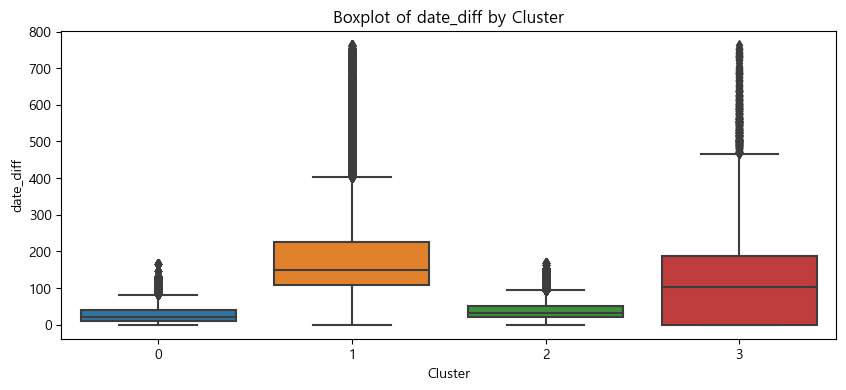

In [78]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=target, x='Cluster', y='date_diff')
plt.title("Boxplot of date_diff by Cluster")
plt.xlabel("Cluster")
plt.ylabel("date_diff")
plt.show()

In [79]:
target['date_diff'].describe()

count    708393.000000
mean         59.052666
std          78.176438
min           0.000000
25%          20.000000
50%          35.000000
75%          65.000000
max         764.000000
Name: date_diff, dtype: float64

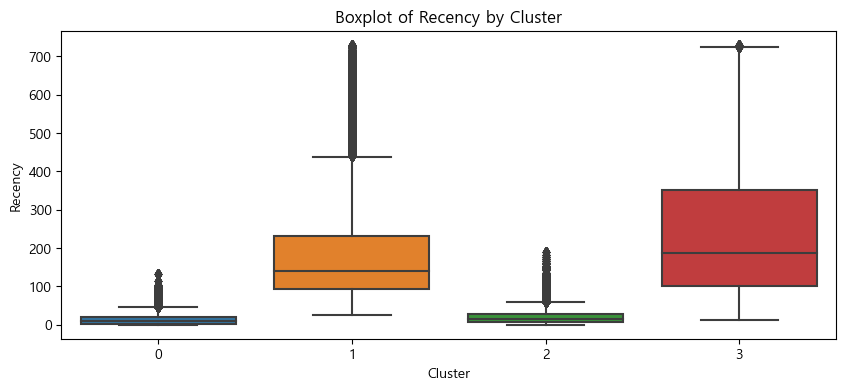

In [80]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=target, x='Cluster', y='Recency')
plt.title("Boxplot of Recency by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Recency")
plt.show()

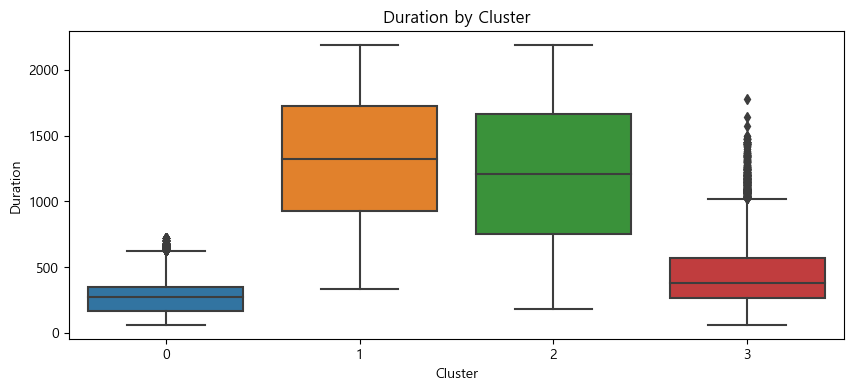

In [81]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=target, x='Cluster', y='Duration')
plt.title("Duration by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Duration")
plt.show()

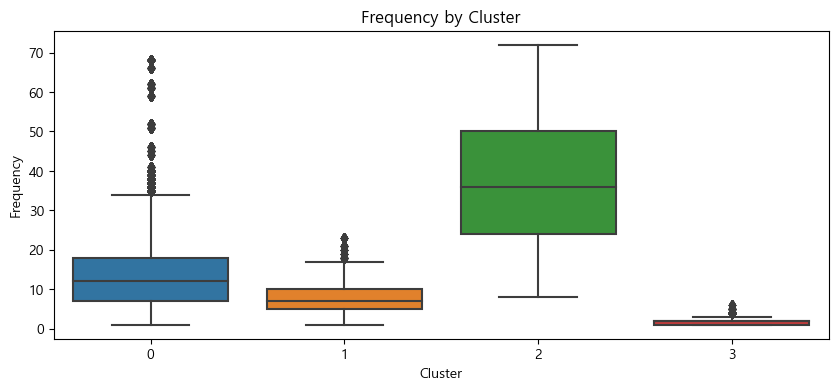

In [82]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=target, x='Cluster', y='Frequency')
plt.title("Frequency by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Frequency")
plt.show()

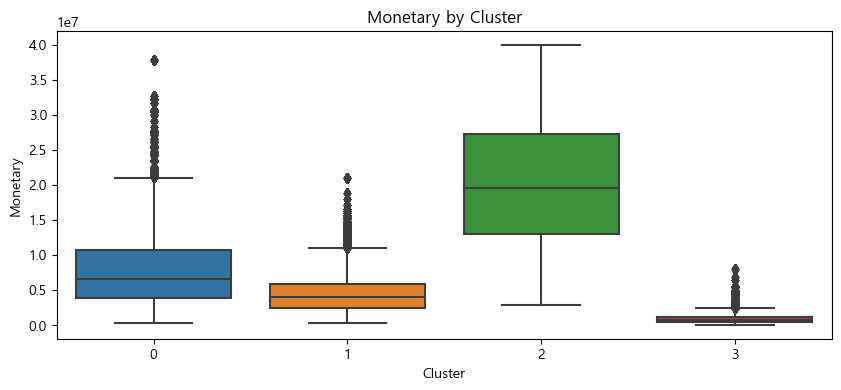

In [83]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=target, x='Cluster', y='Monetary')
plt.title("Monetary by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Monetary")
plt.show()

### payment_method

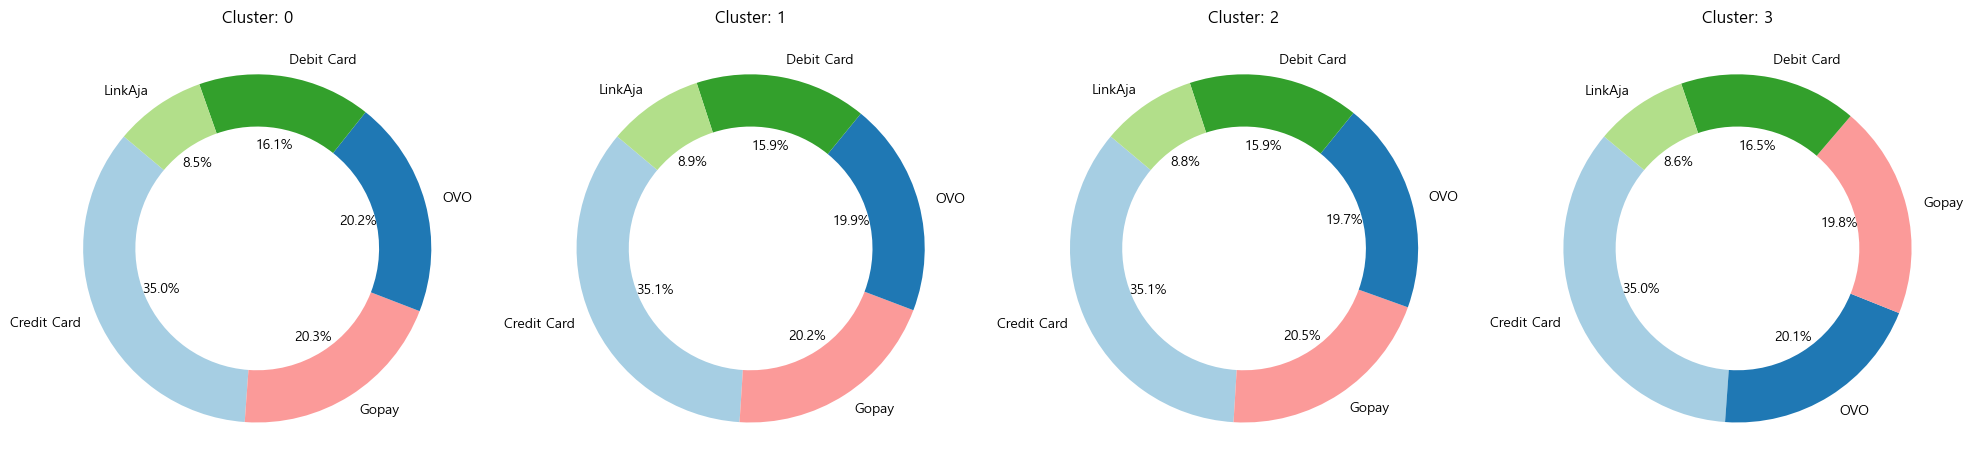

In [84]:
clusters = sorted(target['Cluster'].unique())
unique_sessions = target.drop_duplicates(subset='session_id')

# payment_method에 대한 고정 색상 지정
payment_methods = unique_sessions['payment_method'].unique()
colors = plt.cm.Paired(range(len(payment_methods)))
color_dict = {method: color for method, color in zip(payment_methods, colors)}

fig, axes = plt.subplots(nrows=1, ncols=len(clusters), figsize=(5 * len(clusters), 5))

for ax, cluster in zip(axes, clusters):
    cluster_data = unique_sessions[unique_sessions['Cluster'] == cluster]
    
    payment_method_counts = cluster_data['payment_method'].value_counts(normalize=True)
    
    # payment_method에 대응하는 색상 사용
    method_colors = [color_dict[method] for method in payment_method_counts.index]
    
    ax.pie(payment_method_counts, labels=payment_method_counts.index, colors=method_colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
    ax.set_title(f'Cluster: {cluster}')

plt.tight_layout()
plt.show()

### Home location

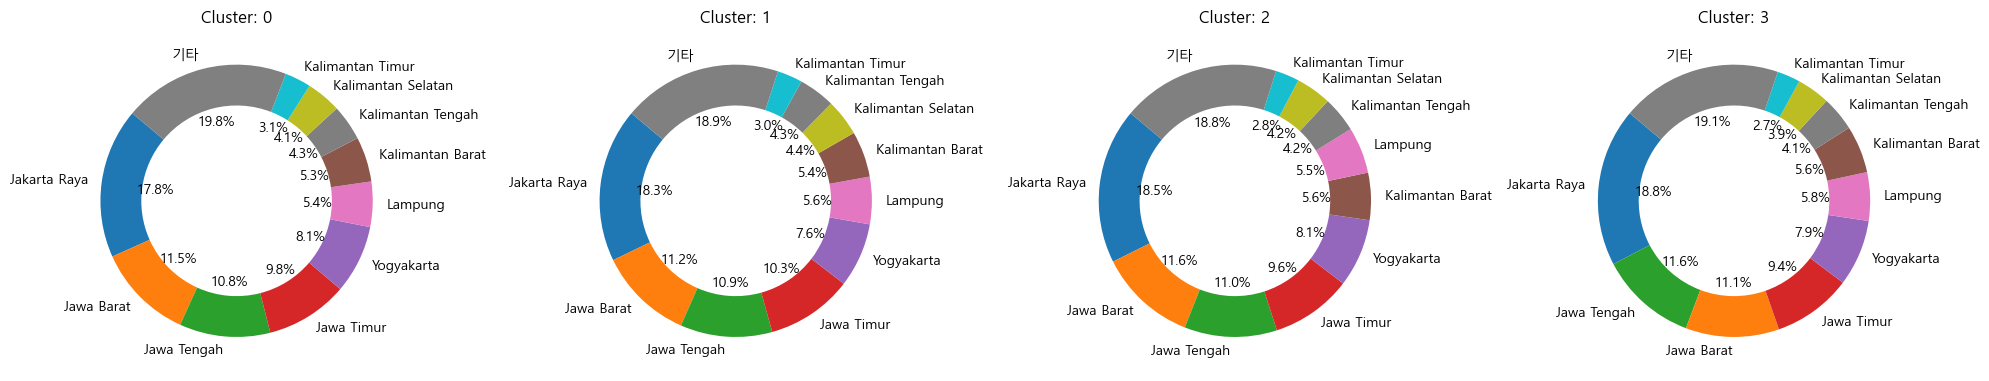

In [85]:
clusters = sorted(target['Cluster'].unique())
unique_sessions = target.drop_duplicates(subset='session_id')

# home_location에 대한 고정 색상 지정
locations = unique_sessions['home_location'].value_counts().index[:10]  # 상위 6개 location
colors = plt.cm.tab10(range(len(locations)))
color_dict = {location: color for location, color in zip(locations, colors)}

fig, axes = plt.subplots(nrows=1, ncols=len(clusters), figsize=(5 * len(clusters), 5))

for ax, cluster in zip(axes, clusters):
    cluster_data = unique_sessions[unique_sessions['Cluster'] == cluster]
    
    home_location_counts = cluster_data['home_location'].value_counts(normalize=True)
    top_locations = home_location_counts[home_location_counts.index.isin(locations)]
    other_percentage = 1 - top_locations.sum()  # 나머지 위치의 백분율

    # '기타' 포함
    labels = list(top_locations.index) + ['기타']
    sizes = list(top_locations) + [other_percentage]
    method_colors = [color_dict.get(location, 'grey') for location in labels]  # '기타'는 회색으로 표시
    
    ax.pie(sizes, labels=labels, colors=method_colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
    ax.set_title(f'Cluster: {cluster}')

plt.tight_layout()
plt.show()

### Promotion

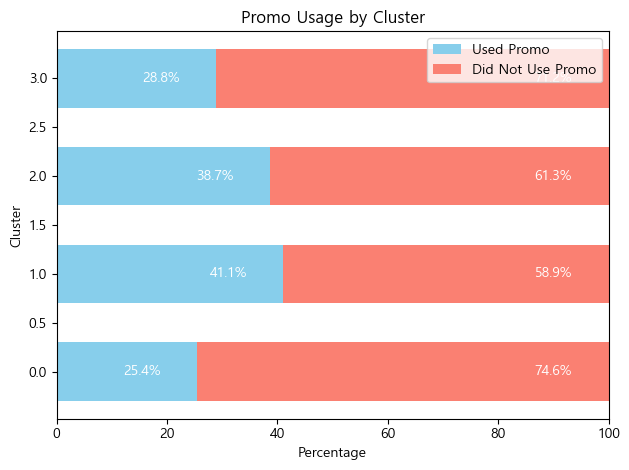

In [86]:
target['is_promo_nonzero'] = target['promo_amount'] != 0
cluster_promo_ratio = target.groupby('Cluster')['is_promo_nonzero'].mean() * 100
no_promo_ratio = 100 - cluster_promo_ratio

# 그래프 그리기
clusters = cluster_promo_ratio.index
bar_width = 0.6  # 막대의 너비

# Promo 사용 비율
bars1 = plt.barh(clusters, cluster_promo_ratio, color='skyblue', label='Used Promo', height=bar_width)
# Promo 미사용 비율
bars2 = plt.barh(clusters, no_promo_ratio, left=cluster_promo_ratio, color='salmon', label='Did Not Use Promo', height=bar_width)

# 각 막대에 텍스트 레이블 추가
for bar in bars1:
    plt.text(bar.get_width() - 10, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.1f}%", ha='center', va='center', color='white', fontsize=10)

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() - 10, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.1f}%", ha='center', va='center', color='white', fontsize=10)

# 그래프 설정
plt.xlabel('Percentage')
plt.ylabel('Cluster')
plt.title('Promo Usage by Cluster')
plt.legend(loc='upper right',bbox_to_anchor=(1,1))
plt.xlim(0, 100)  # x축 범위를 0~100%로 설정
plt.tight_layout()
plt.show()

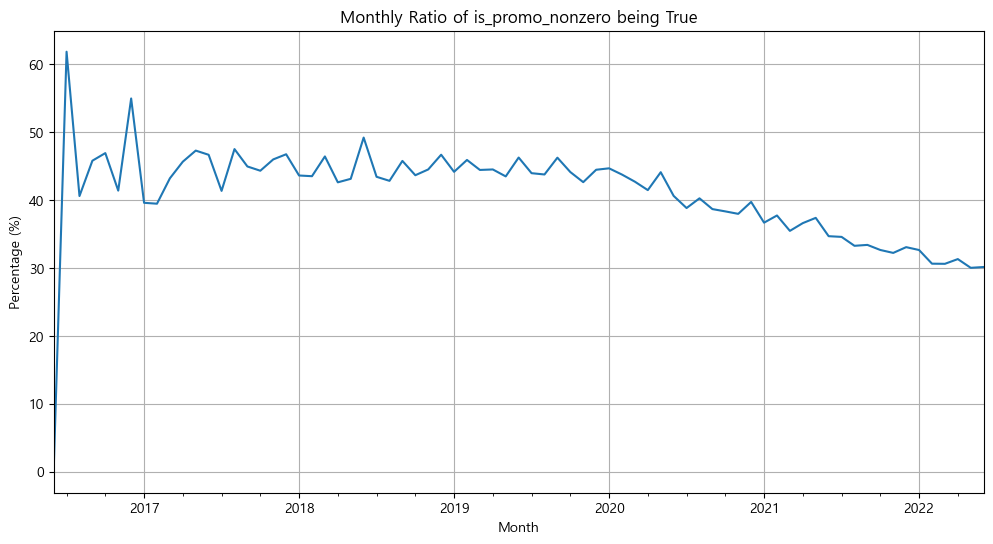

In [87]:
# 월별로 그룹화하고 is_promo_nonzero의 평균을 구합니다.
monthly_promo_ratio = target.groupby('order_month')['is_promo_nonzero'].mean() * 100

# 결과를 시각화합니다.
monthly_promo_ratio.plot(figsize=(12, 6))
plt.title('Monthly Ratio of is_promo_nonzero being True')
plt.ylabel('Percentage (%)')
plt.xlabel('Month')
plt.grid(True)
plt.show()


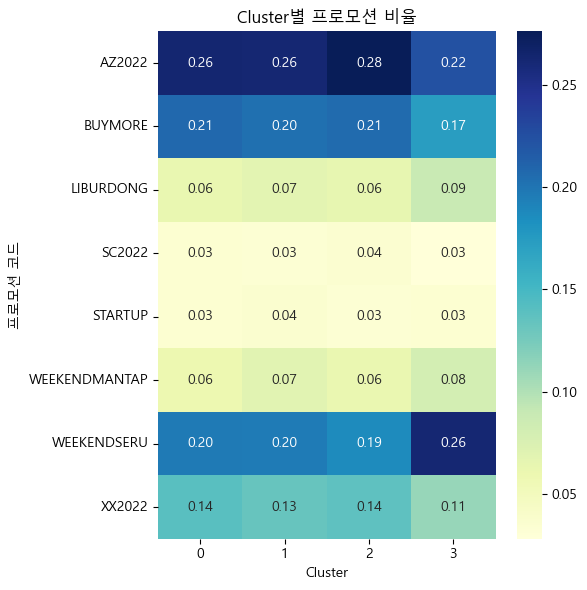

In [88]:
promo = target.query('promo_code != "Not Promoted"')
# 클러스터별 프로모션 코드 빈도 계산
promo_counts_by_cluster = promo.groupby(['Cluster', 'promo_code'])['order_date'].count().reset_index()

# 클러스터별 총 거래 횟수
total_counts_by_cluster = promo_counts_by_cluster.groupby('Cluster')['order_date'].sum()

# 비율 계산
promo_counts_by_cluster['cluster_ratio'] = promo_counts_by_cluster.groupby('Cluster')['order_date'].apply(lambda x: x / total_counts_by_cluster[x.name]).values

# 피벗 테이블로 데이터 변환
pivot_data = promo_counts_by_cluster.pivot(index='promo_code', columns='Cluster', values='cluster_ratio')

# 히트맵
plt.figure(figsize=(6, 6))
sns.heatmap(data=pivot_data, annot=True, fmt=".2f", cmap='YlGnBu', xticklabels=True, yticklabels=True)
plt.xlabel('Cluster')
plt.ylabel('프로모션 코드')
plt.title('Cluster별 프로모션 비율')

plt.tight_layout()
plt.show()

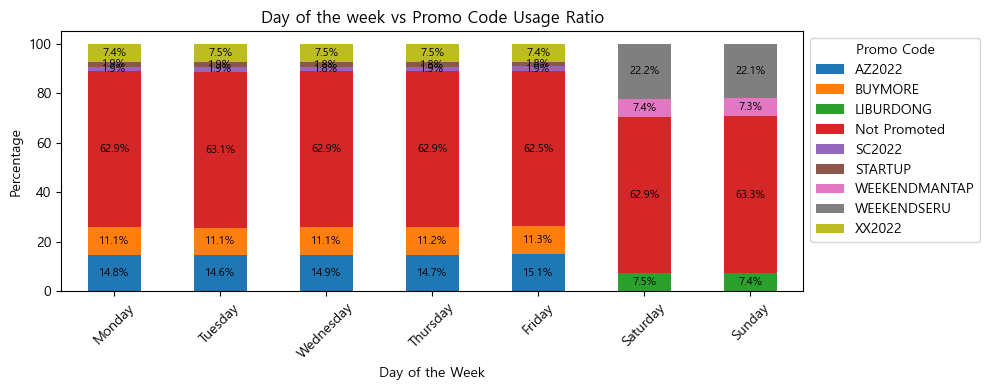

In [89]:
target['day_of_week'] = target['order_date'].dt.day_name()

# promo = target.query('promo_code != "Not Promoted"')
# session_id 별로 중복을 제거합니다.
unique_sessions = target.drop_duplicates(subset='session_id')

# 요일별로 각 promo_code의 사용 횟수를 집계합니다.
promo_counts = unique_sessions.groupby(['day_of_week', 'promo_code']).size().unstack(fill_value=0).reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# 100% 그래프를 생성하기 위해 각 행의 합으로 각 요소를 나눕니다.
promo_ratios = promo_counts.divide(promo_counts.sum(axis=1), axis=0) * 100

# 100% 그래프를 생성하고 각 섹션의 비율을 표시합니다.
ax = promo_ratios.plot(kind='bar', stacked=True, figsize=(10, 4))
plt.title("Day of the week vs Promo Code Usage Ratio")
plt.ylabel("Percentage")
plt.xlabel("Day of the Week")
plt.legend(title="Promo Code", loc="upper left", bbox_to_anchor=(1,1))
plt.xticks(rotation=45)

# 각 섹션에 비율 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:  # Ignore when there's no data
        ax.text(x + width/2, 
                y + height/2, 
                f"{height:.1f}%", 
                horizontalalignment='center', 
                verticalalignment='center',
                fontsize=8, color='black')

plt.tight_layout()
plt.show()


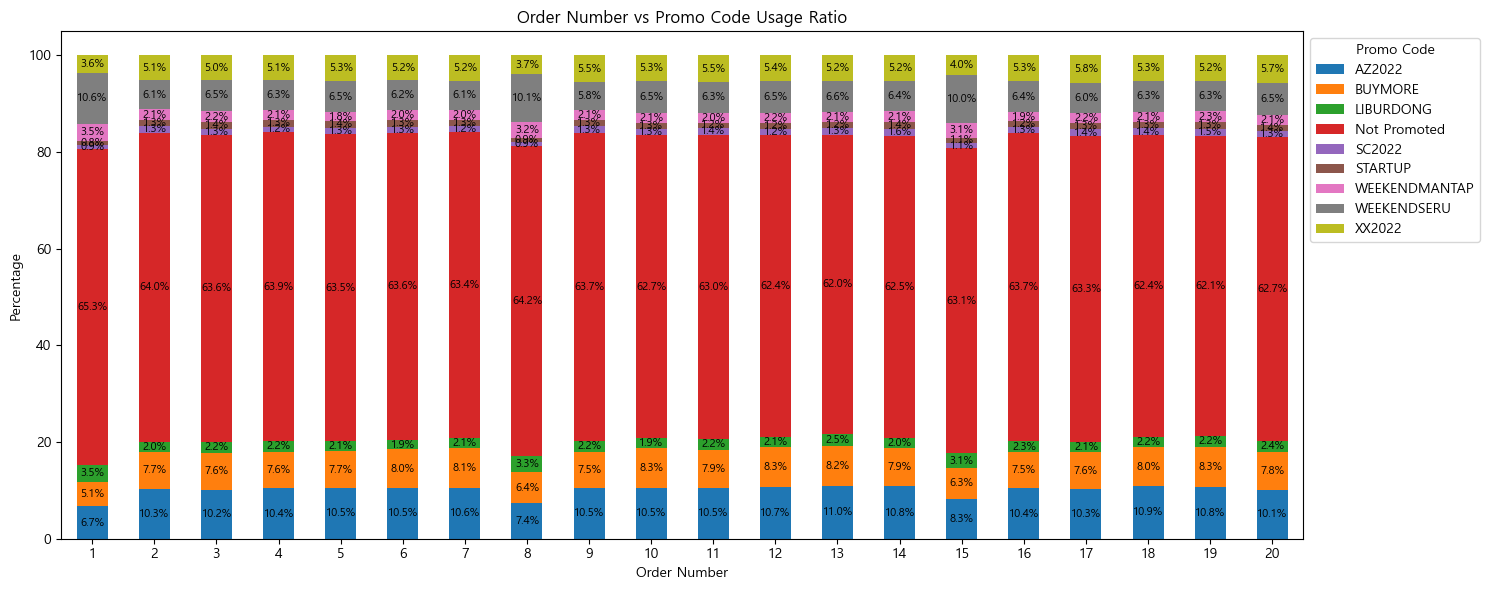

In [90]:
# 할인율 높은 코드가 유입 혹은 지속사용을 유지한다면? 
filtered_sessions = unique_sessions[unique_sessions['order_num'] <= 20]

# order_num 별로 각 promo_code의 사용 횟수를 집계합니다.
promo_counts = filtered_sessions.groupby(['order_num', 'promo_code']).size().unstack(fill_value=0)

# 100% 그래프를 생성하기 위해 각 행의 합으로 각 요소를 나눕니다.
promo_ratios = promo_counts.divide(promo_counts.sum(axis=1), axis=0) * 100

# 결과를 시각화합니다.
ax = promo_ratios.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title("Order Number vs Promo Code Usage Ratio")
plt.ylabel("Percentage")
plt.xlabel("Order Number")
plt.legend(title="Promo Code", loc="upper left", bbox_to_anchor=(1,1))
plt.xticks(rotation=0)

# 각 섹션에 비율 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:  # Ignore when there's no data
        ax.text(x + width/2, 
                y + height/2, 
                f"{height:.1f}%", 
                horizontalalignment='center', 
                verticalalignment='center',
                fontsize=8, color='black')

plt.tight_layout()
plt.show()

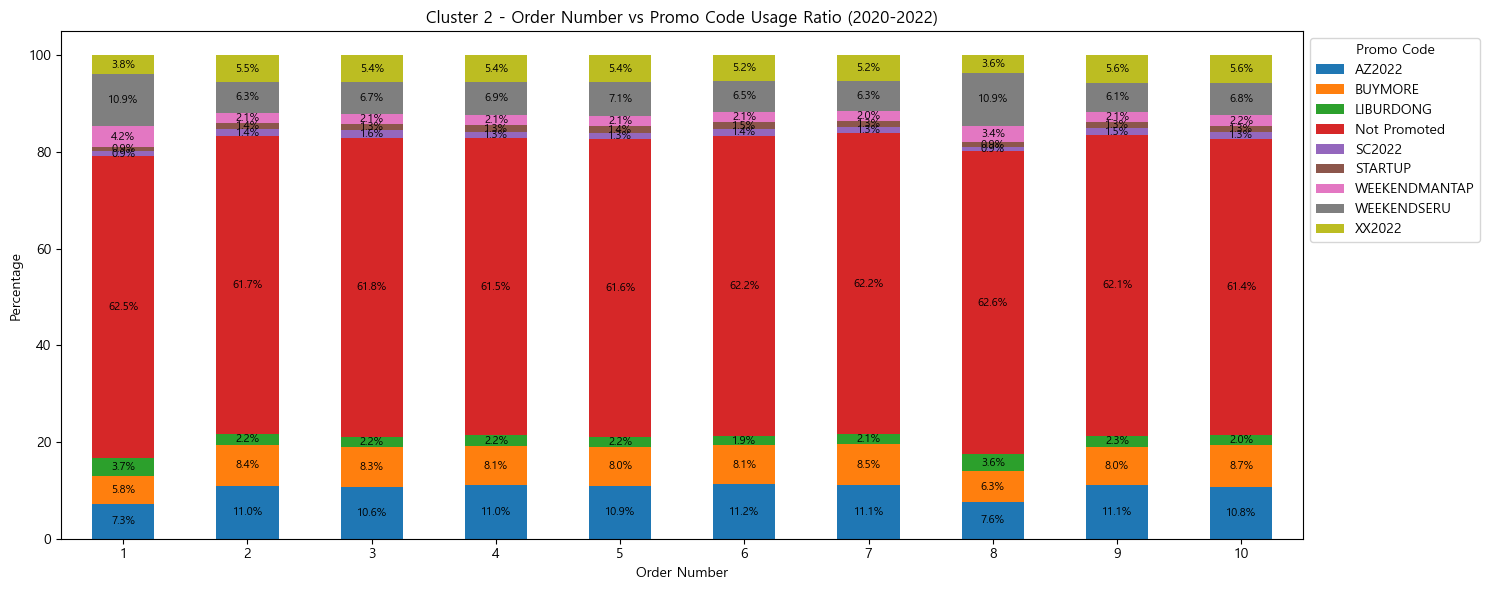

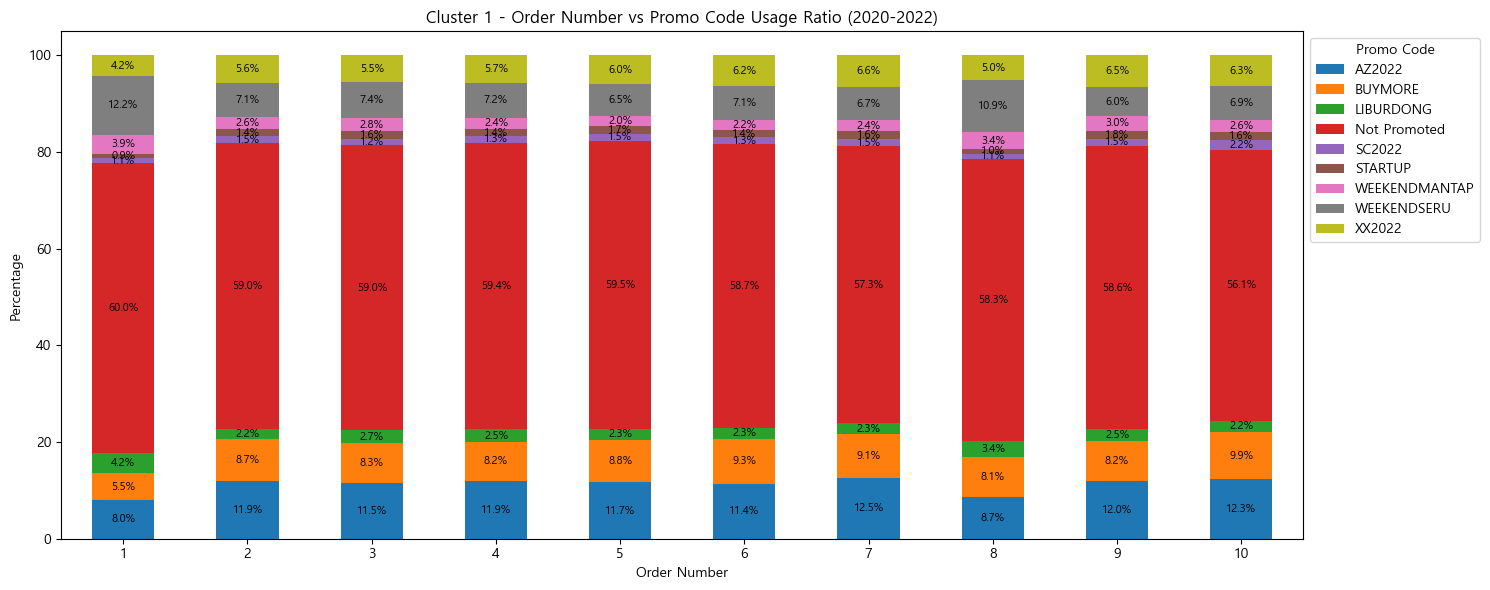

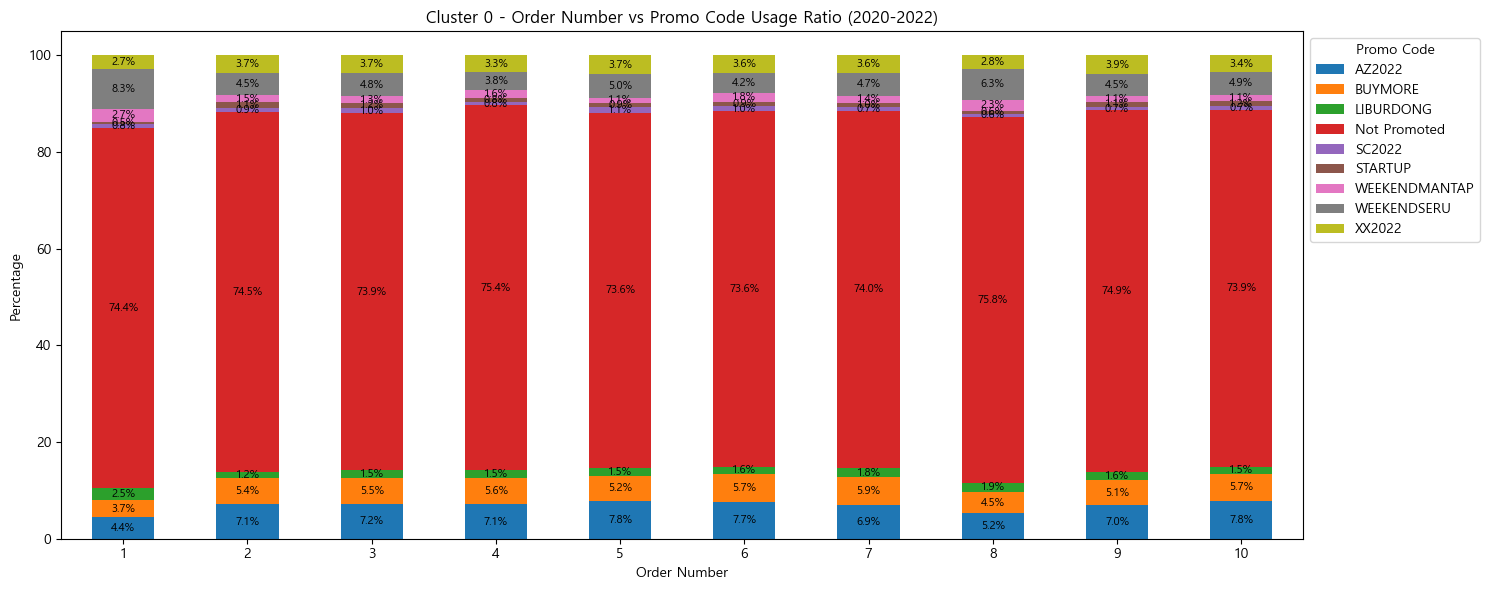

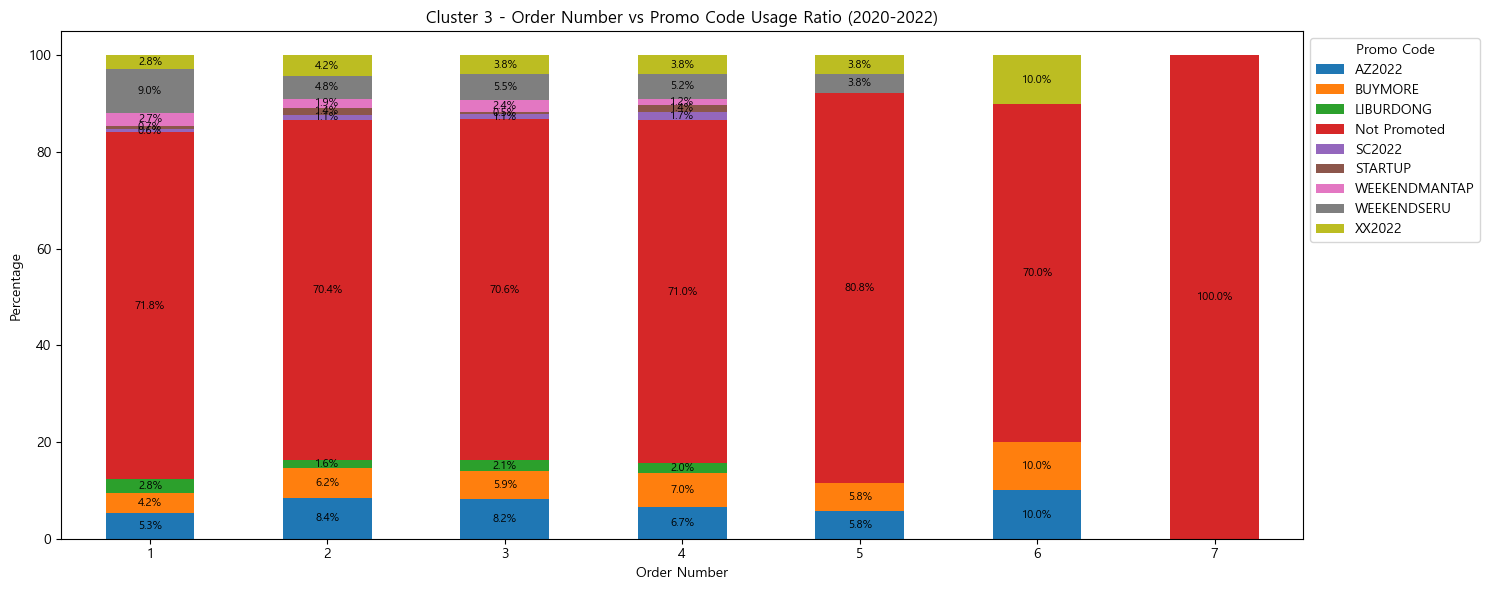

In [91]:
# session_id의 중복을 제외합니다.
unique_sessions = target.drop_duplicates(subset='session_id')

# order_num이 20이하이며 order_year가 2020년부터 2022년까지인 데이터만 필터링합니다.
filtered_sessions = unique_sessions[(unique_sessions['order_num'] <= 10) & (unique_sessions['order_date'].dt.year.between(2017, 2022))]

# 클러스터별로 나누기
clusters = filtered_sessions['Cluster'].unique()

for cluster in clusters:
    cluster_data = filtered_sessions[filtered_sessions['Cluster'] == cluster]
    
    # order_num 별로 각 promo_code의 사용 횟수를 집계합니다.
    promo_counts = cluster_data.groupby(['order_num', 'promo_code']).size().unstack(fill_value=0)
    
    # 100% 그래프를 생성하기 위해 각 행의 합으로 각 요소를 나눕니다.
    promo_ratios = promo_counts.divide(promo_counts.sum(axis=1), axis=0) * 100
    
    # 결과를 시각화합니다.
    ax = promo_ratios.plot(kind='bar', stacked=True, figsize=(15, 6))
    plt.title(f"Cluster {cluster} - Order Number vs Promo Code Usage Ratio (2020-2022)")
    plt.ylabel("Percentage")
    plt.xlabel("Order Number")
    plt.legend(title="Promo Code", loc="upper left", bbox_to_anchor=(1,1))
    plt.xticks(rotation=0)

    # 각 섹션에 비율 표시
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if height > 0:  # Ignore when there's no data
            ax.text(x + width/2, 
                    y + height/2, 
                    f"{height:.1f}%", 
                    horizontalalignment='center', 
                    verticalalignment='center',
                    fontsize=8, color='black')

    plt.tight_layout()
    plt.show()

In [92]:
# session_id의 중복을 제외합니다.
unique_sessions = target.drop_duplicates(subset='session_id')
# order_num이 1인 주문일을 찾습니다.
start_dates = unique_sessions[unique_sessions['order_num'] == 1].set_index('customer_id')['order_date']

# order_num이 8인 주문일을 찾습니다.
end_dates = unique_sessions[unique_sessions['order_num'] == 8].set_index('customer_id')['order_date']

# 두 주문일 사이의 차이를 계산합니다.
durations = (end_dates - start_dates).dropna().dt.days

# 각 customer_id에 대한 클러스터 정보를 가져옵니다.
customer_clusters = target.drop_duplicates(subset='customer_id').set_index('customer_id')['Cluster']

# durations에 클러스터 정보를 합칩니다.
durations_with_cluster = pd.concat([durations, customer_clusters], axis=1).dropna()

# 클러스터별로 평균 이용기간을 계산합니다.
average_durations_by_cluster = durations_with_cluster.groupby('Cluster')['order_date'].mean()

print(average_durations_by_cluster)

Cluster
0    187.610476
1    982.664692
2    327.848636
Name: order_date, dtype: float64


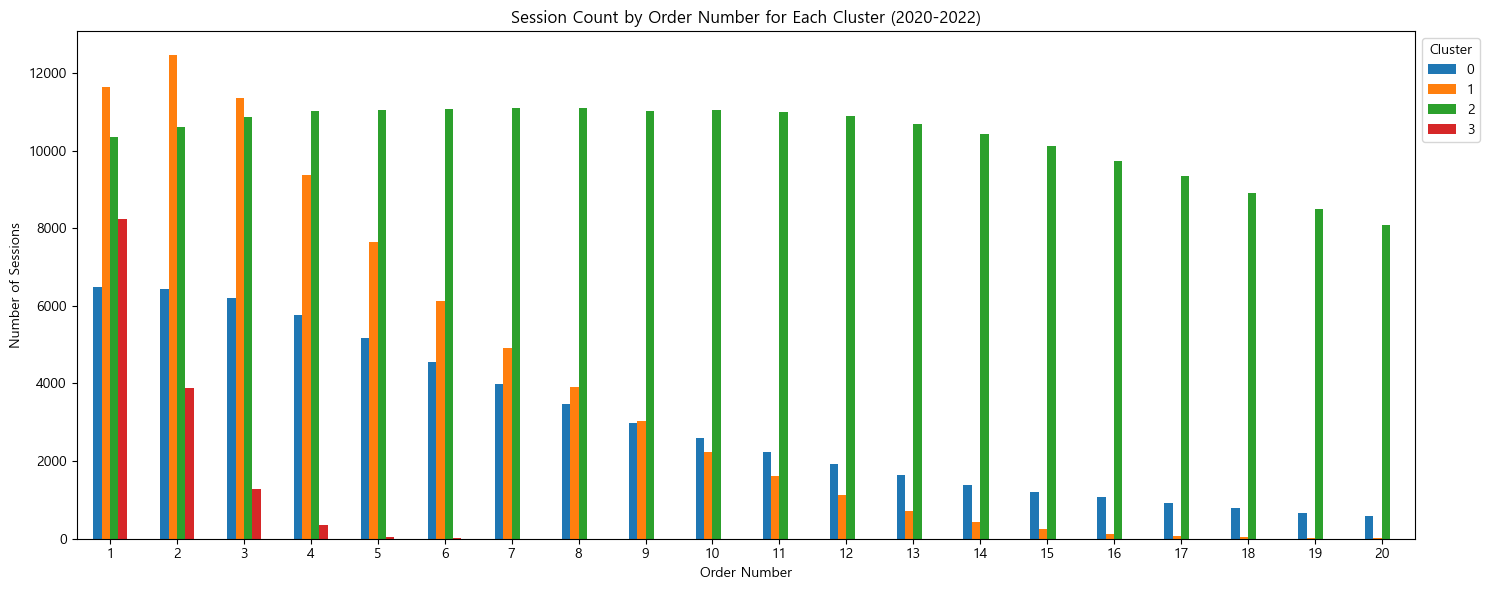

In [93]:
# order_date에서 연도만 추출하여 'order_year' 컬럼을 생성합니다.
unique_sessions['order_year'] = unique_sessions['order_date'].dt.year

# order_num이 20이하이며 order_year가 2020년부터 2022년까지인 데이터만 필터링합니다.
filtered_sessions = unique_sessions[(unique_sessions['order_num'] <= 20) & (unique_sessions['order_year'].between(2017, 2022))]

# 클러스터와 order_num 별로 session_id의 수를 집계합니다.
session_counts = filtered_sessions.groupby(['Cluster', 'order_num'])['session_id'].size().unstack(fill_value=0)

# 결과를 시각화합니다.
ax = session_counts.T.plot(kind='bar', figsize=(15, 6))
plt.title("Session Count by Order Number for Each Cluster (2020-2022)")
plt.ylabel("Number of Sessions")
plt.xlabel("Order Number")
plt.legend(title="Cluster", loc="upper left", bbox_to_anchor=(1,1))
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


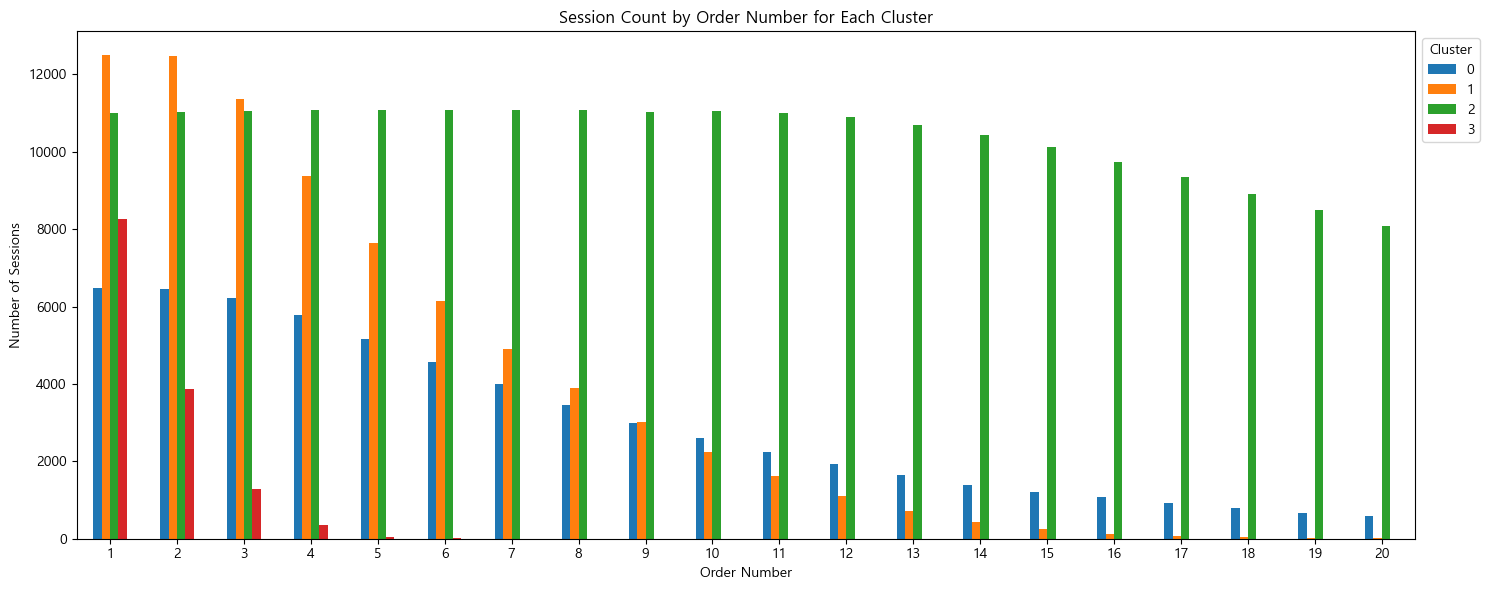

In [94]:
# session_id의 중복을 제외합니다.
unique_sessions = target.drop_duplicates(subset='session_id')

# order_num이 20이하인 데이터만 필터링
filtered_sessions = unique_sessions[unique_sessions['order_num'] <= 20]

# 클러스터와 order_num 별로 session_id의 수를 집계합니다.
session_counts = filtered_sessions.groupby(['Cluster', 'order_num'])['session_id'].size().unstack(fill_value=0)

# 결과를 시각화합니다.
ax = session_counts.T.plot(kind='bar', figsize=(15, 6))
plt.title("Session Count by Order Number for Each Cluster")
plt.ylabel("Number of Sessions")
plt.xlabel("Order Number")
plt.legend(title="Cluster", loc="upper left", bbox_to_anchor=(1,1))
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

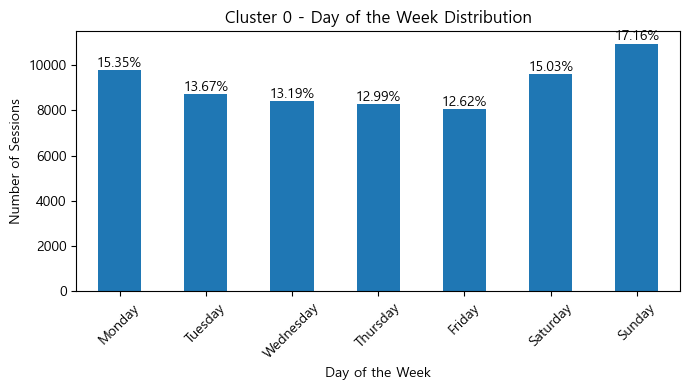

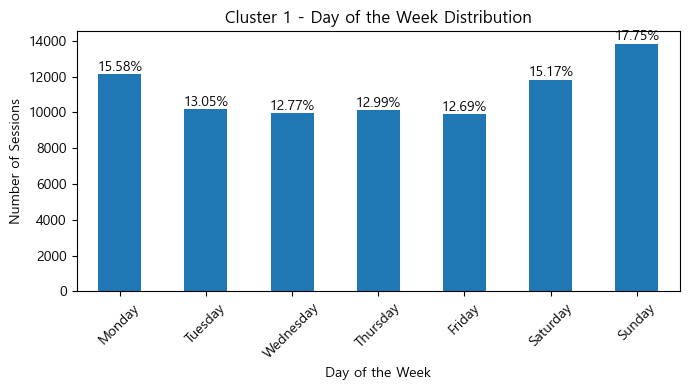

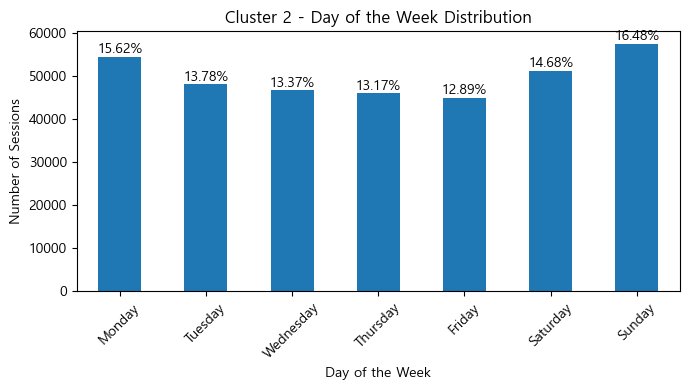

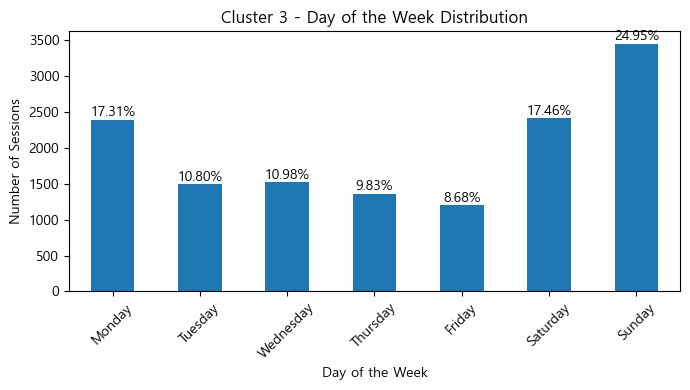

In [95]:
unique_sessions = target.drop_duplicates(subset='session_id')
# 요일 정보를 추가합니다.
unique_sessions['day_of_week'] = unique_sessions['order_date'].dt.day_name()

# 클러스터별로 나누기
clusters = sorted(unique_sessions['Cluster'].unique())

for cluster in clusters:
    cluster_data = unique_sessions[unique_sessions['Cluster'] == cluster]
    
    # 요일별 데이터 수를 집계합니다.
    day_counts = cluster_data['day_of_week'].value_counts().reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    
    # 각 요일별 데이터가 전체 데이터 대비 어느 정도의 비율을 차지하는지 계산합니다.
    day_ratios = (day_counts / day_counts.sum()) * 100
    
    # 결과를 시각화합니다.
    ax = day_counts.plot(kind='bar', figsize=(7, 4))
    plt.title(f"Cluster {cluster} - Day of the Week Distribution")
    plt.ylabel("Number of Sessions")
    plt.xlabel("Day of the Week")
    plt.xticks(rotation=45)

    for idx, p in enumerate(ax.patches):
        ax.annotate(f"{day_ratios[idx]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()


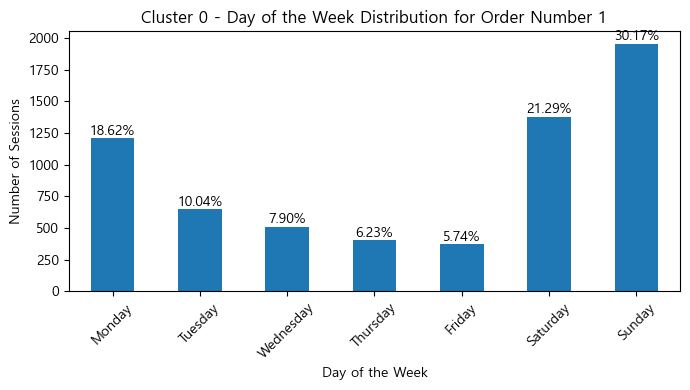

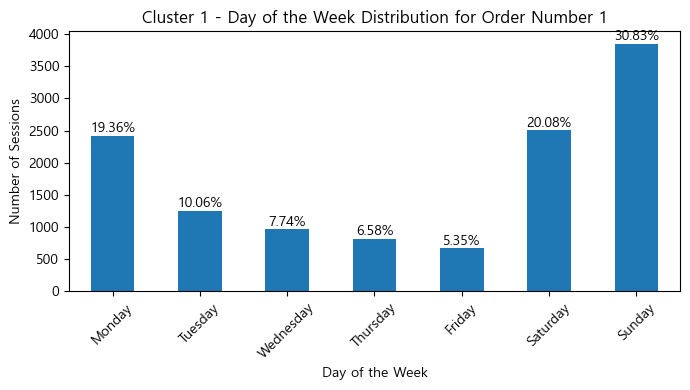

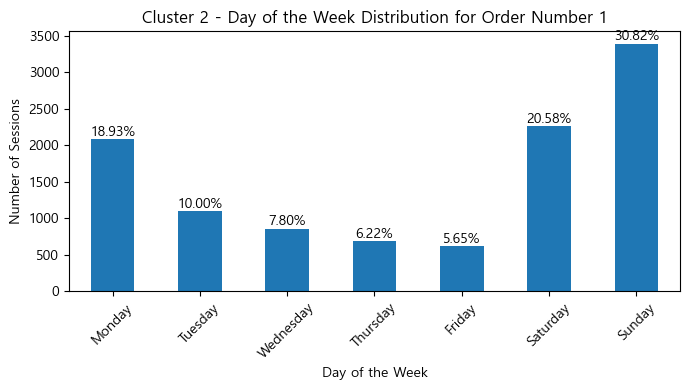

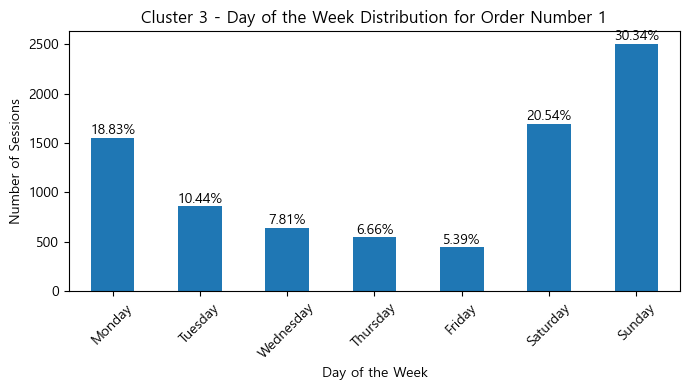

In [96]:
unique_sessions = target.drop_duplicates(subset='session_id')

# order_num이 1인 데이터만 필터링합니다.
filtered_sessions = unique_sessions[unique_sessions['order_num'] == 1]

# 요일 정보를 추가합니다.
filtered_sessions['day_of_week'] = filtered_sessions['order_date'].dt.day_name()

# 클러스터별로 나누기
clusters = sorted(filtered_sessions['Cluster'].unique())

for cluster in clusters:
    cluster_data = filtered_sessions[filtered_sessions['Cluster'] == cluster]
    
    # 요일별 데이터 수를 집계합니다.
    day_counts = cluster_data['day_of_week'].value_counts().reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    
    # 각 요일별 데이터가 전체 데이터 대비 어느 정도의 비율을 차지하는지 계산합니다.
    day_ratios = (day_counts / day_counts.sum()) * 100
    
    # 결과를 시각화합니다.
    ax = day_counts.plot(kind='bar', figsize=(7, 4))
    plt.title(f"Cluster {cluster} - Day of the Week Distribution for Order Number 1")
    plt.ylabel("Number of Sessions")
    plt.xlabel("Day of the Week")
    plt.xticks(rotation=45)

    for idx, p in enumerate(ax.patches):
        ax.annotate(f"{day_ratios[idx]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()


In [97]:
# promo_amount가 0이 아닌 데이터를 필터링
filtered_data = target[target['promo_amount'] != 0]

# session_id 별로 price의 합계를 계산
price_sum_per_session = filtered_data.groupby('session_id')['price'].sum()

# session_id 별로 첫번째 promo_amount 값을 가져옵니다.
first_promo_per_session = filtered_data.groupby('session_id').first()['promo_amount']

# 두 데이터프레임을 병합
merged_data = pd.concat([first_promo_per_session, price_sum_per_session], axis=1)

# 비율 계산
merged_data['ratio'] = merged_data['promo_amount'] / merged_data['price']

# session_id를 reset_index로 다시 가져와서 병합합니다.
merged_data = merged_data.reset_index().merge(filtered_data[['session_id', 'promo_code']].drop_duplicates(), on='session_id')

# promo_code 별로 비율의 평균을 계산
average_ratio_per_promo = merged_data.groupby('promo_code')['ratio'].mean()*100

average_ratio_per_promo

promo_code
AZ2022           1.960367
BUYMORE          1.963840
LIBURDONG        1.946522
SC2022           3.933555
STARTUP          3.943172
WEEKENDMANTAP    1.948077
WEEKENDSERU      1.943900
XX2022           1.954375
Name: ratio, dtype: float64

In [98]:
exchange_rate = 0.087  # 1원당 0.087원 환율

# 'order_date'에서 연도를 추출합니다.
target['year'] = target['order_date'].dt.year

# 연도별로 2017~2022년까지의 데이터를 분석합니다.
results = {}
for year in range(2017, 2023):
    year_data = target[target['year'] == year]
    
    # promo_amount가 0이 아닌 데이터를 필터링
    filtered_data = year_data[year_data['promo_amount'] != 0]

    # session_id 별로 price의 합계를 계산
    price_sum_per_session = filtered_data.groupby(['session_id', 'promo_code'])['price'].sum().reset_index()

    # session_id 별로 첫번째 promo_amount 값을 가져옵니다.
    first_promo_per_session = filtered_data.groupby(['session_id', 'promo_code']).first()['promo_amount'].reset_index()

    # 두 데이터프레임을 병합
    merged_data = pd.merge(price_sum_per_session, first_promo_per_session, on=['session_id', 'promo_code'])

    # 비율 계산
    merged_data['ratio'] = merged_data['promo_amount'] / merged_data['price']*100

    # promo_code 별로 price의 평균 합계와 비율의 평균을 계산
    average_values_per_promo = merged_data.groupby('promo_code').agg({'price': 'mean', 'ratio': 'mean'})
    
    # 환율 적용
    average_values_per_promo['price'] = average_values_per_promo['price'] * exchange_rate
    
    results[year] = average_values_per_promo.round(2)

# 결과를 DataFrame으로 변환하여 출력합니다.
final_results = pd.concat(results, axis=1)
final_results


2017            2018            2019            2020        \
                  price ratio     price ratio     price ratio     price ratio   
promo_code                                                                      
AZ2022         47446.48  1.92  47401.70  1.94  46803.77  1.98  46116.97  1.97   
BUYMORE        45189.46  2.02  47526.97  1.92  46590.36  1.96  46329.71  1.95   
LIBURDONG      50615.62  1.96  44462.59  1.89  48735.12  1.91  48105.52  1.95   
SC2022         48053.65  3.61  51685.81  3.88  45754.59  3.88  45227.21  4.00   
STARTUP        49688.87  3.93  49844.02  4.04  48302.82  3.89  47713.41  3.89   
WEEKENDMANTAP  42412.24  1.99  49515.74  1.88  46043.76  1.97  48167.96  1.91   
WEEKENDSERU    42903.19  1.99  48377.11  1.90  45858.37  1.94  47222.83  1.93   
XX2022         49496.90  1.92  43763.28  1.99  47065.17  1.93  47799.54  1.93   

                   2021            2022        
                  price ratio     price ratio  
promo_code                                     
AZ2022         47093.13  1.95  46119.14  1.97  
BUYMORE        47225.85  1.98  47359.47  1.96  
LIBURDONG      48102.09  1.96  47343.48  1.98  
SC2022         48691.43  3.89  46026.10  4.04  
STARTUP        47607.32  3.98  45595.16  3.96  
WEEKENDMANTAP  46265.93  1.94  46183.99  2.01  
WEEKENDSERU    46867.45  1.95  46952.44  1.96  
XX2022         45420.48  1.98  45741.59  1.94

In [99]:
# 'order_date'에서 연도를 추출합니다.
target['year'] = target['order_date'].dt.year

# 연도별로 2017~2022년까지의 데이터를 분석합니다.
results = {}
for year in range(2017, 2023):
    year_data = target[target['year'] == year]
    
    # promo_amount가 0이 아닌 데이터를 필터링
    filtered_data = year_data[year_data['promo_amount'] != 0]

    # session_id 별로 price의 합계를 계산
    price_sum_per_session = filtered_data.groupby('session_id')['price'].sum()

    # session_id 별로 첫번째 promo_amount 값을 가져옵니다.
    first_promo_per_session = filtered_data.groupby('session_id').first()['promo_amount']

    # 두 데이터프레임을 병합
    merged_data = pd.concat([first_promo_per_session, price_sum_per_session], axis=1)

    # 비율 계산
    merged_data['ratio'] = merged_data['promo_amount'] / merged_data['price']

    # session_id를 reset_index로 다시 가져와서 병합합니다.
    merged_data = merged_data.reset_index().merge(filtered_data[['session_id', 'promo_code']].drop_duplicates(), on='session_id')

    # promo_code 별로 비율의 평균을 계산
    average_ratio_per_promo = merged_data.groupby('promo_code')['ratio'].mean()*100
    
    results[year] = average_ratio_per_promo

# 결과를 DataFrame으로 변환하여 출력합니다.
final_results = pd.DataFrame(results)
final_results

2017      2018      2019      2020      2021      2022
promo_code                                                               
AZ2022         1.917949  1.936407  1.981437  1.973599  1.948740  1.967068
BUYMORE        2.024117  1.923909  1.961322  1.949136  1.980436  1.961981
LIBURDONG      1.960216  1.886147  1.913926  1.945498  1.962564  1.978924
SC2022         3.607356  3.875705  3.876823  4.003822  3.888900  4.037865
STARTUP        3.932876  4.041077  3.894917  3.893922  3.980349  3.957235
WEEKENDMANTAP  1.985974  1.881640  1.968027  1.911048  1.944000  2.007347
WEEKENDSERU    1.994087  1.900828  1.944557  1.931838  1.948557  1.956741
XX2022         1.922783  1.990769  1.926300  1.934650  1.983857  1.941498

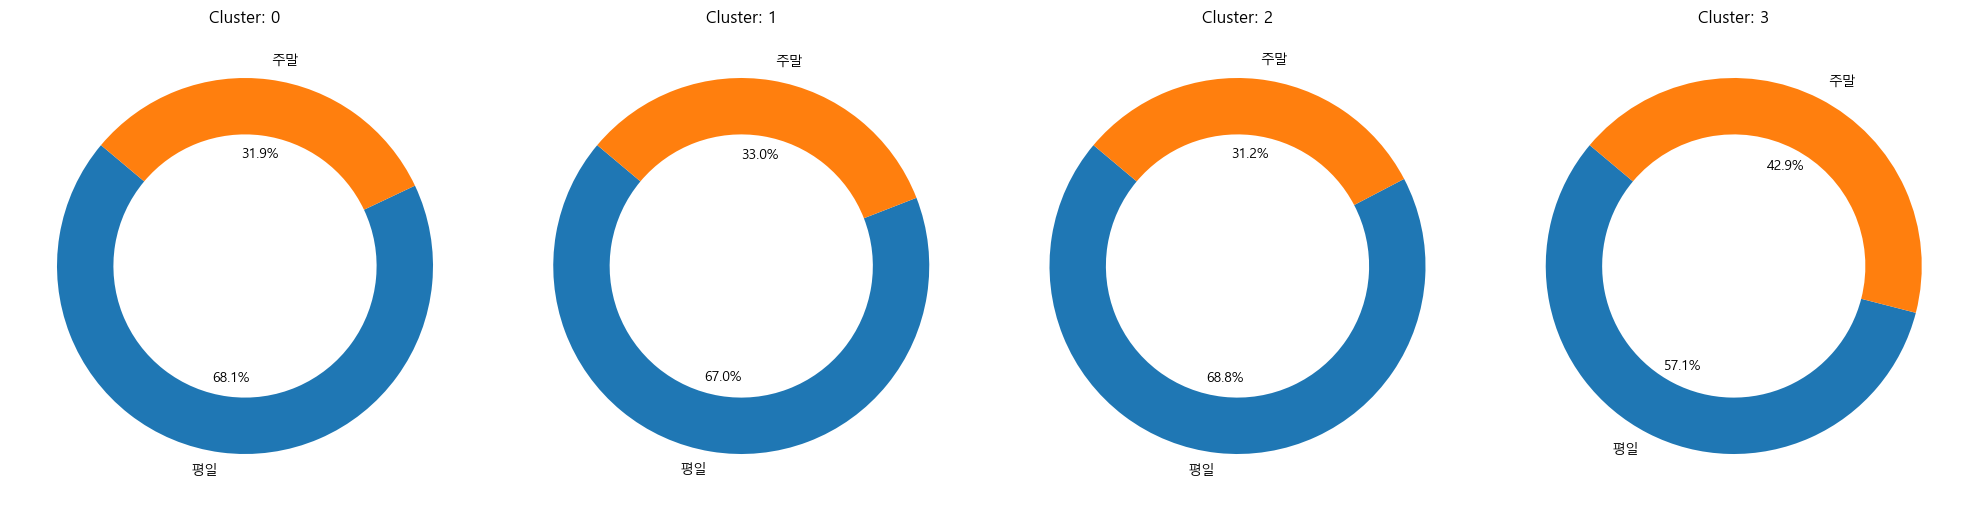

In [100]:
# unique_sessions = df.drop_duplicates(subset='session_id')

# # order_date에서 요일 정보를 추출하여 '주말'과 '평일'로 분류하는 새로운 컬럼 'day_type'을 생성합니다.
# unique_sessions['day_type'] = unique_sessions['order_date'].dt.dayofweek.map({0: '평일', 1: '평일', 2: '평일', 3: '평일', 4: '평일', 5: '주말', 6: '주말'})

# order_date에서 요일 정보를 추출하여 '주말'과 '평일'로 분류하는 새로운 컬럼 'day_type'을 생성합니다.
target['day_type'] = target['order_date'].dt.dayofweek.map({0: '평일', 1: '평일', 2: '평일', 3: '평일', 4: '평일', 5: '주말', 6: '주말'})

clusters = sorted(target['Cluster'].unique())

# 클러스터의 수만큼 subplot을 생성합니다.
fig, axes = plt.subplots(nrows=1, ncols=len(clusters), figsize=(5 * len(clusters), 5))

for ax, cluster in zip(axes, clusters):
    cluster_data = target[target['Cluster'] == cluster]
    
    # 클러스터와 거래요일별로 데이터를 집계합니다.
    day_type_counts = cluster_data['day_type'].value_counts(normalize=True)
    
    ax.pie(day_type_counts, labels=day_type_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
    ax.set_title(f'Cluster: {cluster}')

plt.tight_layout()
plt.show()

In [101]:
# pd.set_option('display.float_format', '{:.2f}'.format)

In [102]:
# session_id 별로 quantity_price의 합을 계산
target['total_per_session'] = target.groupby('session_id')['price'].transform('sum')

# 클러스터와 is_promo_nonzero 조건별로 최소값, 최대값, 평균값 계산
result = target.groupby(['Cluster', 'is_promo_nonzero']).agg({
    'total_per_session': ['min', 'max', 'mean']
}).reset_index()

# 결과 출력
print(result)

  Cluster is_promo_nonzero total_per_session                        
                                         min       max          mean
0       0            False             11185  14615529  1.162730e+06
1       0             True             26569  12149423  1.147914e+06
2       1            False             16991  16545348  1.150467e+06
3       1             True             28265  17167401  1.090300e+06
4       2            False             20972  19586054  1.180257e+06
5       2             True             12402  21702841  1.163708e+06
6       3            False             21885   7900593  6.387173e+05
7       3             True             28525   7910114  6.499333e+05


In [103]:
# 프로모션 사용주기

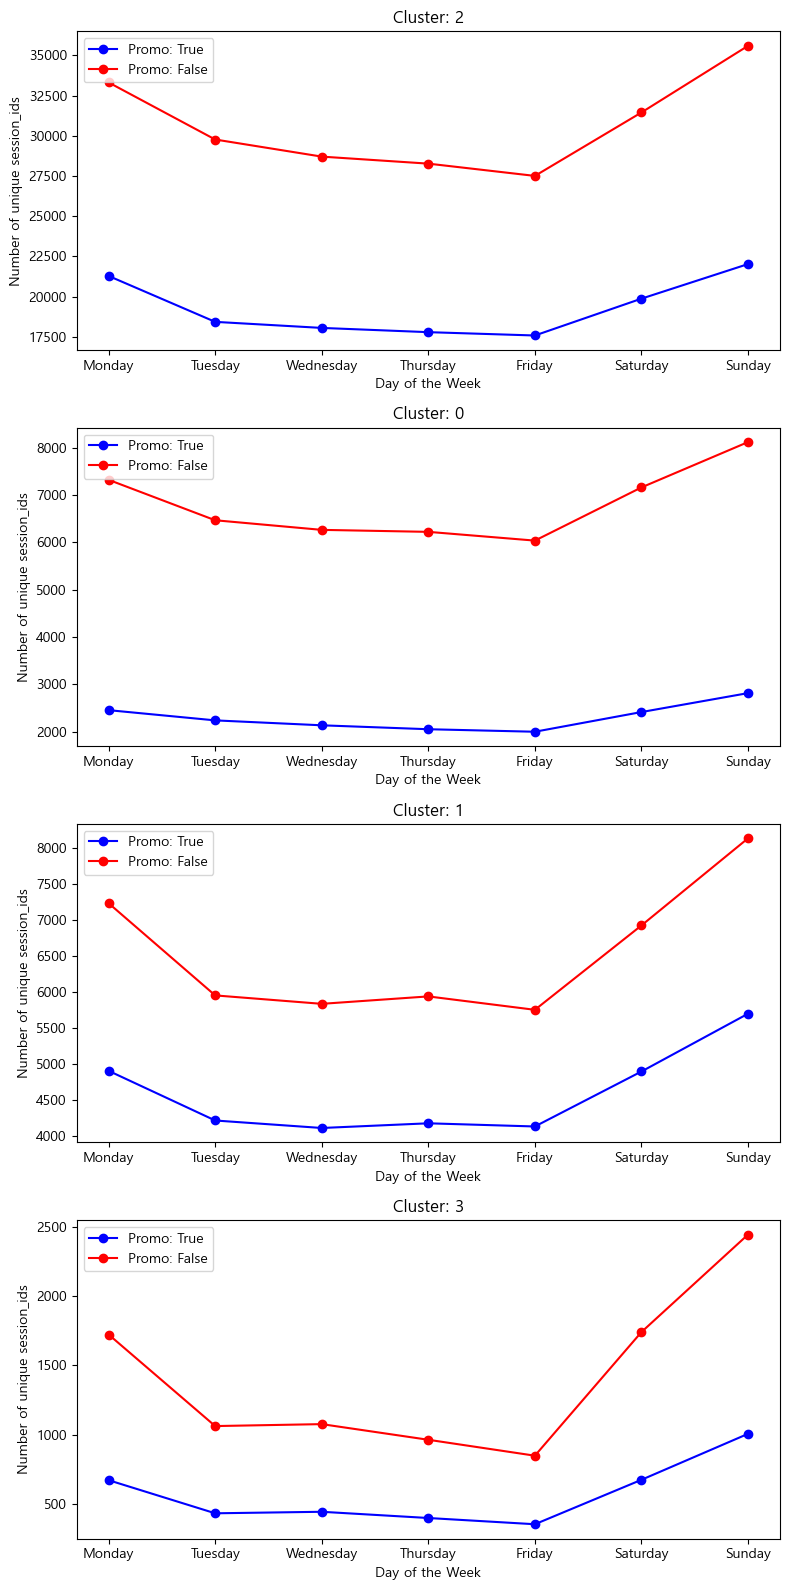

In [104]:
# order_date에서 요일 정보를 가져와 'day_of_week' 컬럼을 생성합니다.
target['day_of_week'] = target['order_date'].dt.day_name()

# 필요한 cluster들의 목록을 가져옵니다.
clusters = target['Cluster'].unique()

# cluster의 수만큼 subplot을 생성합니다.
fig, axes = plt.subplots(nrows=len(clusters), ncols=1, figsize=(8, 4*len(clusters)))

# 요일 순서를 명시적으로 정의합니다.
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

for ax, cluster in zip(axes, clusters):
    # 해당 cluster의 데이터만 필터링합니다.
    cluster_data = target[target['Cluster'] == cluster]

    # is_promo_nonzero 값이 True인 경우와 False인 경우로 나눠서 집계합니다.
    for promo_status, color in zip([True, False], ['b', 'r']):
        promo_data = cluster_data[cluster_data['is_promo_nonzero'] == promo_status]
        session_counts = promo_data.groupby('day_of_week')['session_id'].nunique().reindex(days_order)
        session_counts.plot(ax=ax, label=f'Promo: {promo_status}', color=color, marker='o')

    ax.set_title(f'Cluster: {cluster}')
    ax.set_ylabel('Number of unique session_ids')
    ax.set_xlabel('Day of the Week')
    ax.legend()

plt.tight_layout()
plt.show()

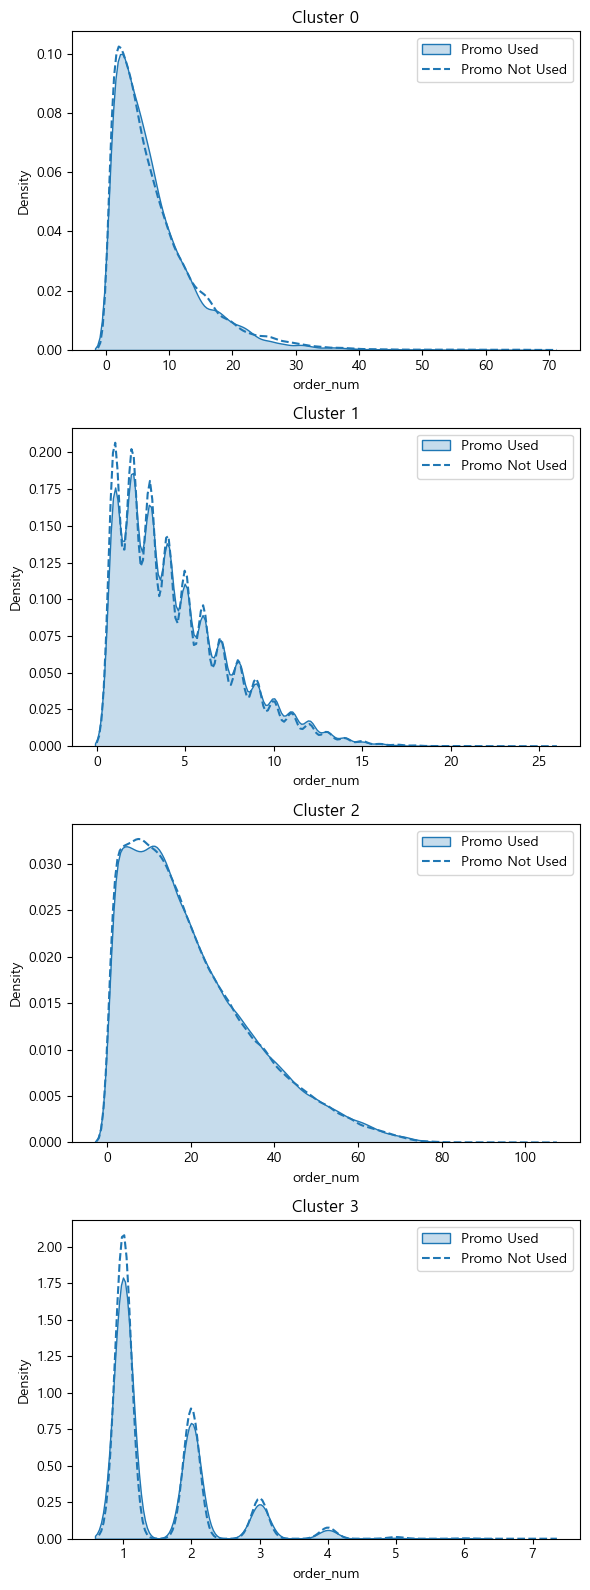

In [105]:
clusters = sorted(target['Cluster'].unique())
n_clusters = len(clusters)

fig, axes = plt.subplots(n_clusters, 1, figsize=(6, 4 * n_clusters))

for i, cluster in enumerate(clusters):
    cluster_data = target[target['Cluster'] == cluster]
    sns.kdeplot(cluster_data[cluster_data['is_promo_nonzero'] == 1]['order_num'], ax=axes[i], shade=True, label='Promo Used')
    sns.kdeplot(cluster_data[cluster_data['is_promo_nonzero'] == 0]['order_num'], ax=axes[i], linestyle='--', label='Promo Not Used')
    axes[i].set_title(f'Cluster {cluster}')
    axes[i].set_xlabel('order_num')
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [106]:
# 주기가 30일 이상인사람. 30일 미만인사람

In [107]:
# 회당 구매가격 

# 클러스터와 session_id별로 총 매출 합계
total_sales_per_cluster = target.groupby(['Cluster', 'session_id'])['price'].sum().reset_index()

# 클러스터별 주문 횟수
order_counts_per_cluster = target.groupby('Cluster')['session_id'].nunique().reset_index(name='order_count')

# 클러스터별 객단가 계산
avg_sales_per_cluster = total_sales_per_cluster.groupby('Cluster')['price'].mean().reset_index(name='avg_sales')

result = pd.merge(avg_sales_per_cluster, order_counts_per_cluster, on='Cluster')
result['avg_sales']  # 이 값이 클러스터별 세션당 평균 구매 가격

0    542363.797960
1    537027.990993
2    542620.318366
3    396984.858766
Name: avg_sales, dtype: float64

In [108]:
# 각 세션의 구매품목 수 계산
session_item_counts = target.groupby('session_id').size().reset_index(name='item_count')

# 세션 정보와 클러스터 정보를 합침
merged = session_item_counts.merge(target[['session_id', 'Cluster']].drop_duplicates(), on='session_id')

# 클러스터별로 세션당 구매품목 수의 평균 계산
cluster_avg_item_counts = merged.groupby('Cluster')['item_count'].mean()

print(cluster_avg_item_counts)

Cluster
0    1.469120
1    1.461651
2    1.473187
3    1.264742
Name: item_count, dtype: float64


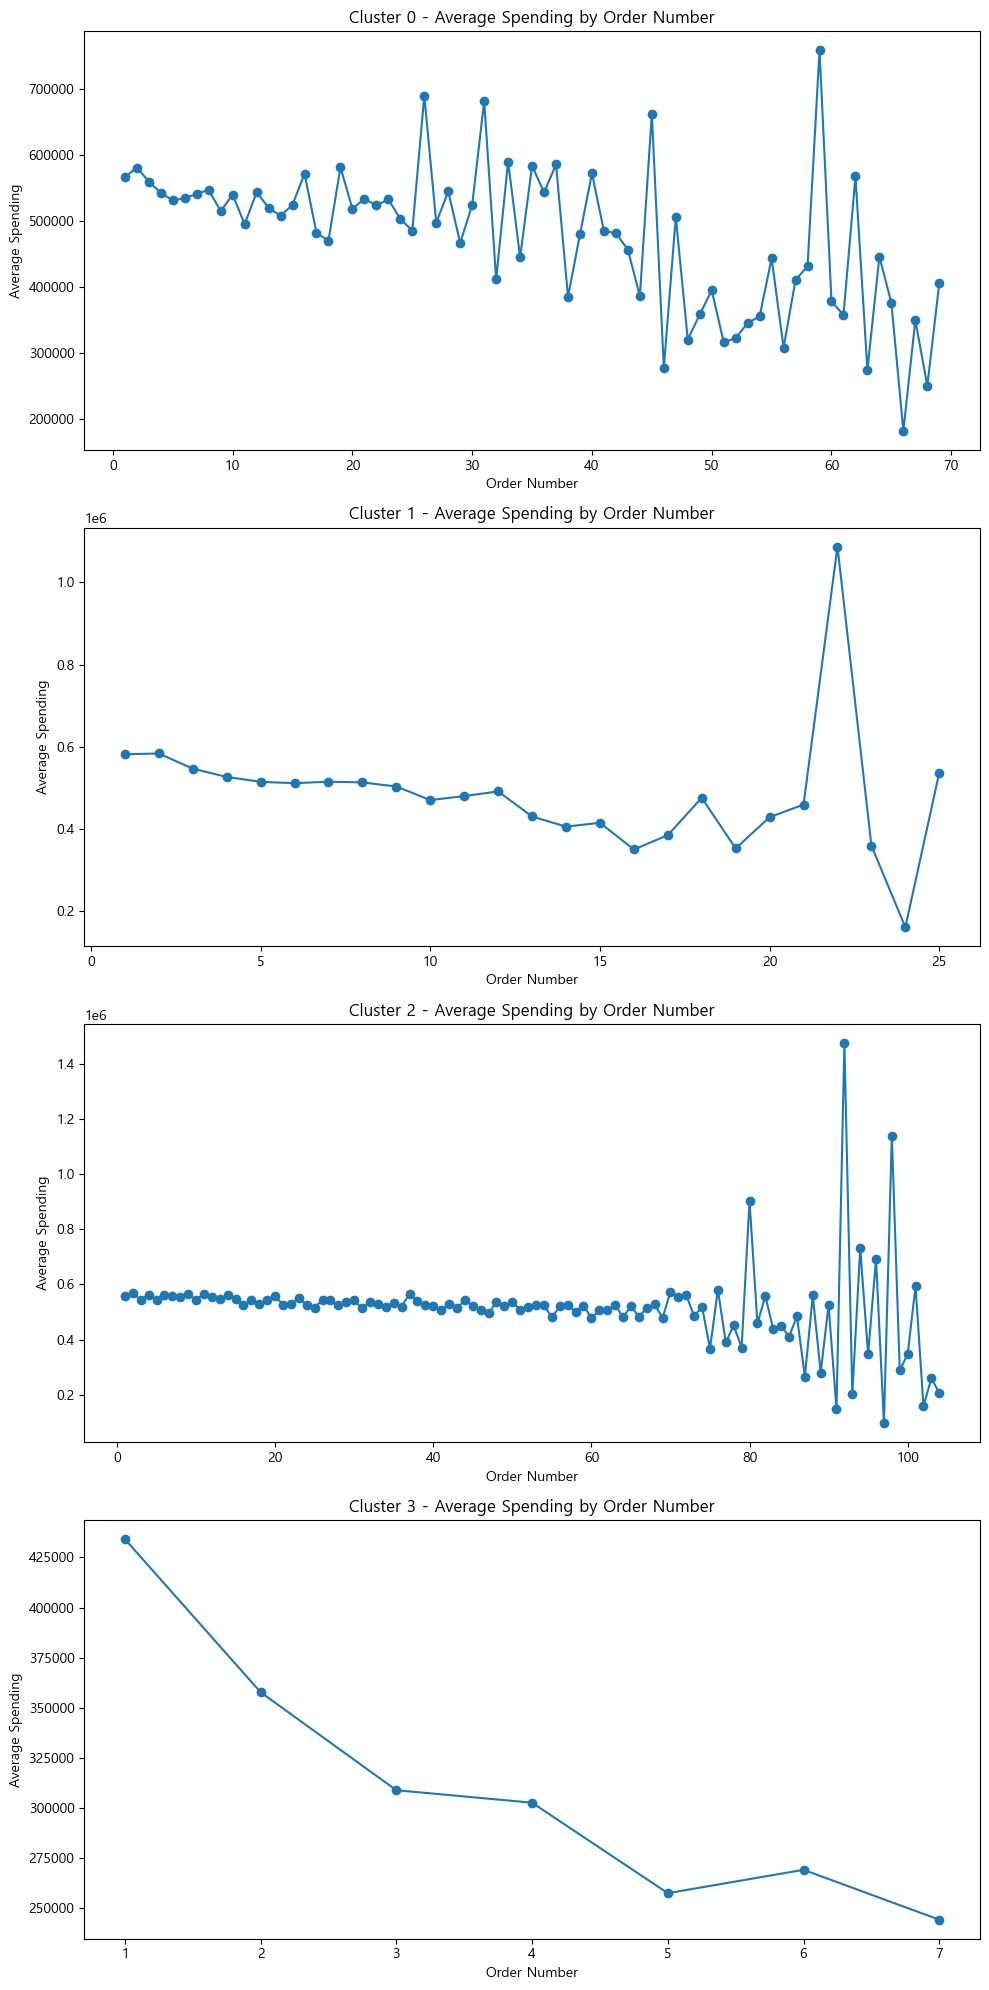

In [109]:
session_prices = target.groupby(['customer_id', 'session_id', 'order_num', 'Cluster'])['price'].sum().reset_index()

# order_num와 Cluster를 기준으로 그룹화하여 객단가를 계산합니다.
avg_spending = session_prices.groupby(['Cluster', 'order_num'])['price'].mean().unstack()

clusters = sorted(target['Cluster'].unique())
fig, axes = plt.subplots(len(clusters), 1, figsize=(10, 5 * len(clusters)))

for i, cluster in enumerate(clusters):
    axes[i].plot(avg_spending.columns, avg_spending.loc[cluster], marker='o', linestyle='-')
    axes[i].set_title(f"Cluster {cluster} - Average Spending by Order Number")
    axes[i].set_ylabel("Average Spending")
    axes[i].set_xlabel("Order Number")
    
plt.tight_layout()
plt.show()

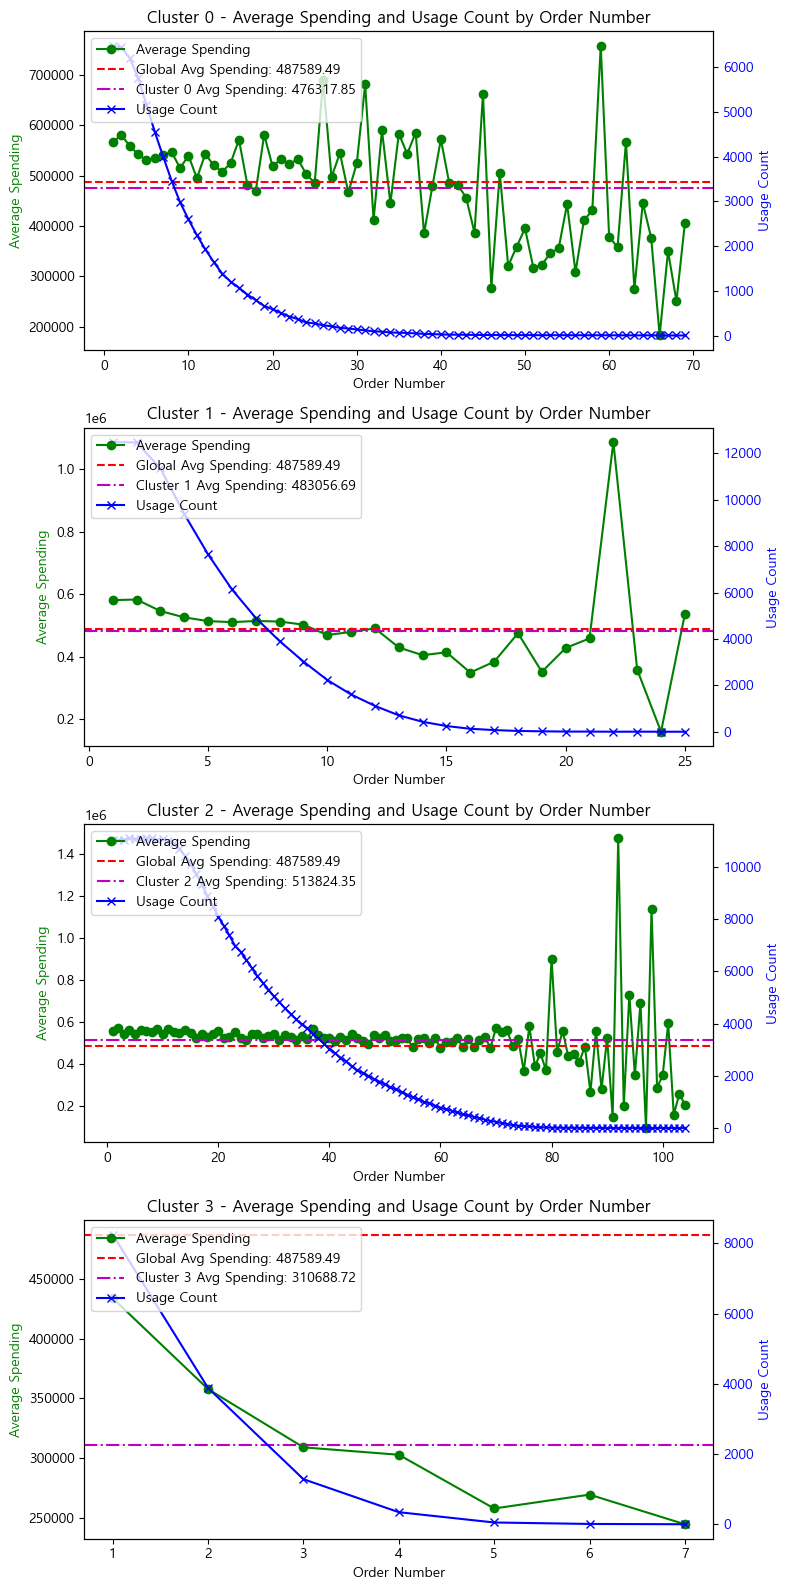

In [110]:
session_prices = target.groupby(['customer_id', 'session_id', 'order_num', 'Cluster'])['price'].sum().reset_index()

# order_num와 Cluster를 기준으로 그룹화하여 객단가를 계산합니다.
avg_spending = session_prices.groupby(['Cluster', 'order_num'])['price'].mean().unstack()

# order_num와 Cluster를 기준으로 이용 횟수를 계산합니다.
usage_counts = target.groupby(['Cluster', 'order_num'])['session_id'].nunique().unstack()

# 객단가의 전체 평균을 계산합니다.
global_avg_spending = avg_spending.mean().mean()
cluster_avg_spending = avg_spending.mean(axis=1)

clusters = sorted(target['Cluster'].unique())
fig, axes = plt.subplots(len(clusters), 1, figsize=(8, 4 * len(clusters)))

for i, cluster in enumerate(clusters):
    ax1 = axes[i]
    ax2 = ax1.twinx()  # 두 번째 Y축 생성

    # 객단가를 첫 번째 Y축에 표시
    ax1.plot(avg_spending.columns, avg_spending.loc[cluster], 'g-', marker='o', label="Average Spending")
    ax1.axhline(global_avg_spending, color="r", linestyle="--", label=f"Global Avg Spending: {global_avg_spending:.2f}")
    ax1.axhline(cluster_avg_spending[cluster], color="m", linestyle="-.", label=f"Cluster {cluster} Avg Spending: {cluster_avg_spending[cluster]:.2f}")  
    ax1.set_title(f"Cluster {cluster} - Average Spending and Usage Count by Order Number")
    ax1.set_ylabel("Average Spending", color="g")
    ax1.set_xlabel("Order Number")
    
    # 이용 횟수를 두 번째 Y축에 표시
    ax2.plot(usage_counts.columns, usage_counts.loc[cluster], 'b-', marker='x', label="Usage Count")
    ax2.set_ylabel("Usage Count", color="b")
    ax2.tick_params(axis='y', labelcolor="b")

    # 범례 표시
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc=2)

plt.tight_layout()
plt.show()

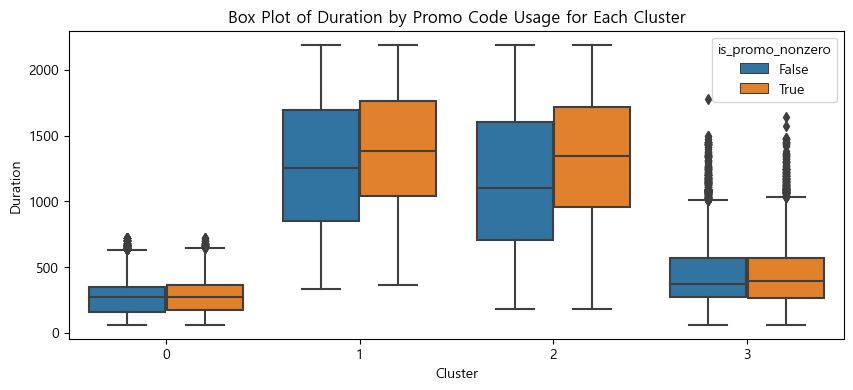

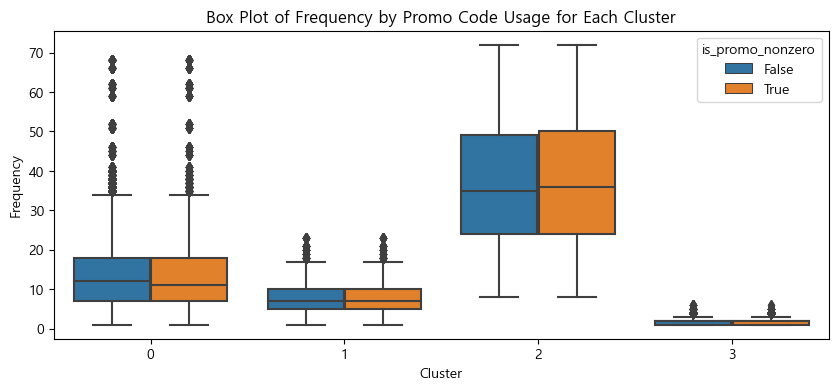

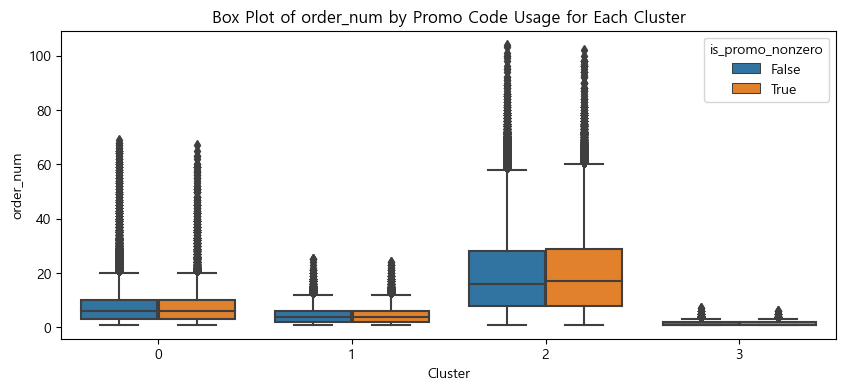

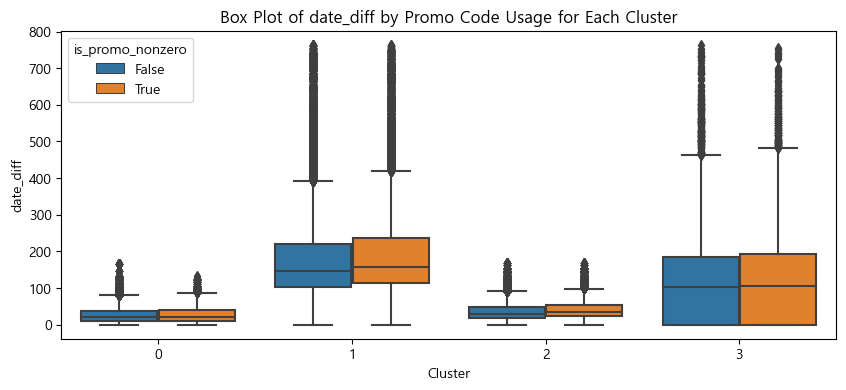

In [111]:
features = ['Duration', 'Frequency', 'order_num', 'date_diff']

for feature in features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='Cluster', y=feature, hue='is_promo_nonzero', data=target)
    plt.title(f'Box Plot of {feature} by Promo Code Usage for Each Cluster')
    plt.show()

### PRODUCT

In [112]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


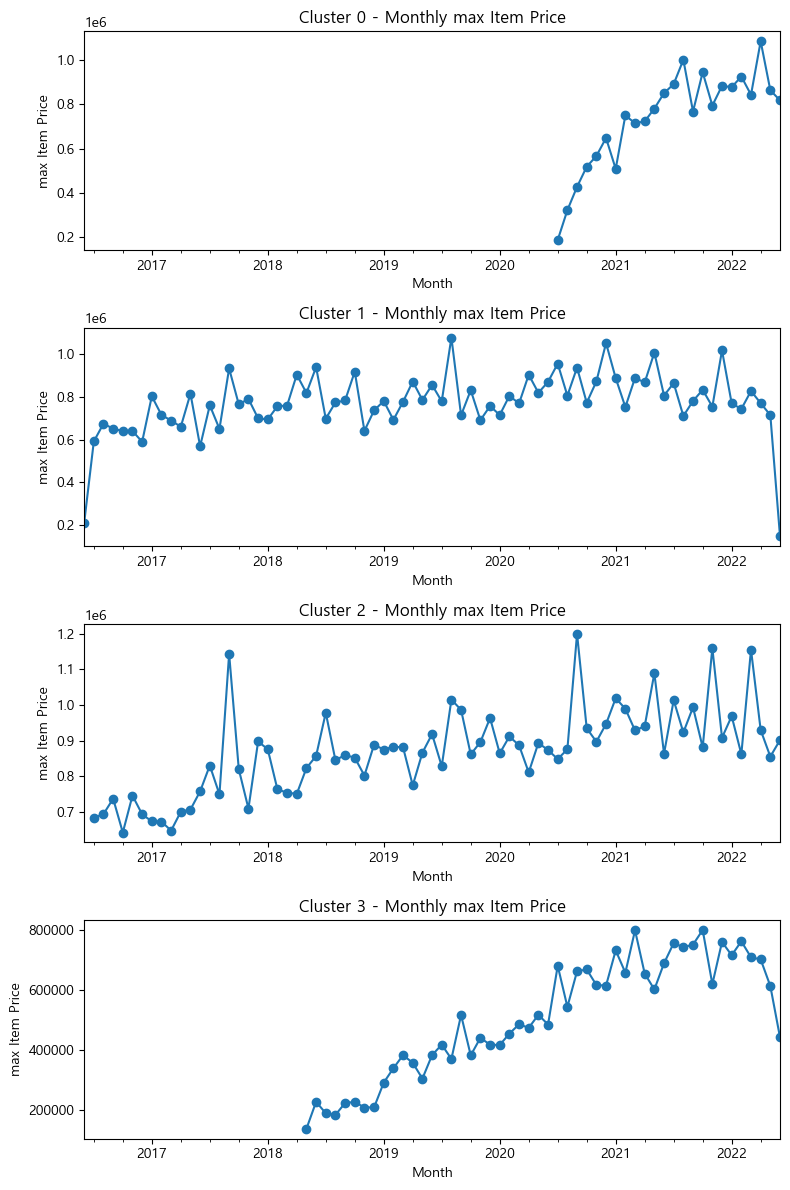

In [113]:
# 클러스터와 year_month로 그룹화하여 item_price의 max 계산합니다.
monthly_avg_prices = target.groupby(['Cluster', 'order_month'])['item_price'].max().unstack().transpose()

clusters = sorted(target['Cluster'].unique())
fig, axes = plt.subplots(len(clusters), 1, figsize=(8, 3 * len(clusters)))

for i, cluster in enumerate(clusters):
    monthly_avg_prices[cluster].plot(ax=axes[i], marker='o')
    axes[i].set_title(f"Cluster {cluster} - Monthly max Item Price")
    axes[i].set_ylabel("max Item Price")
    axes[i].set_xlabel("Month")

plt.tight_layout()
plt.show()

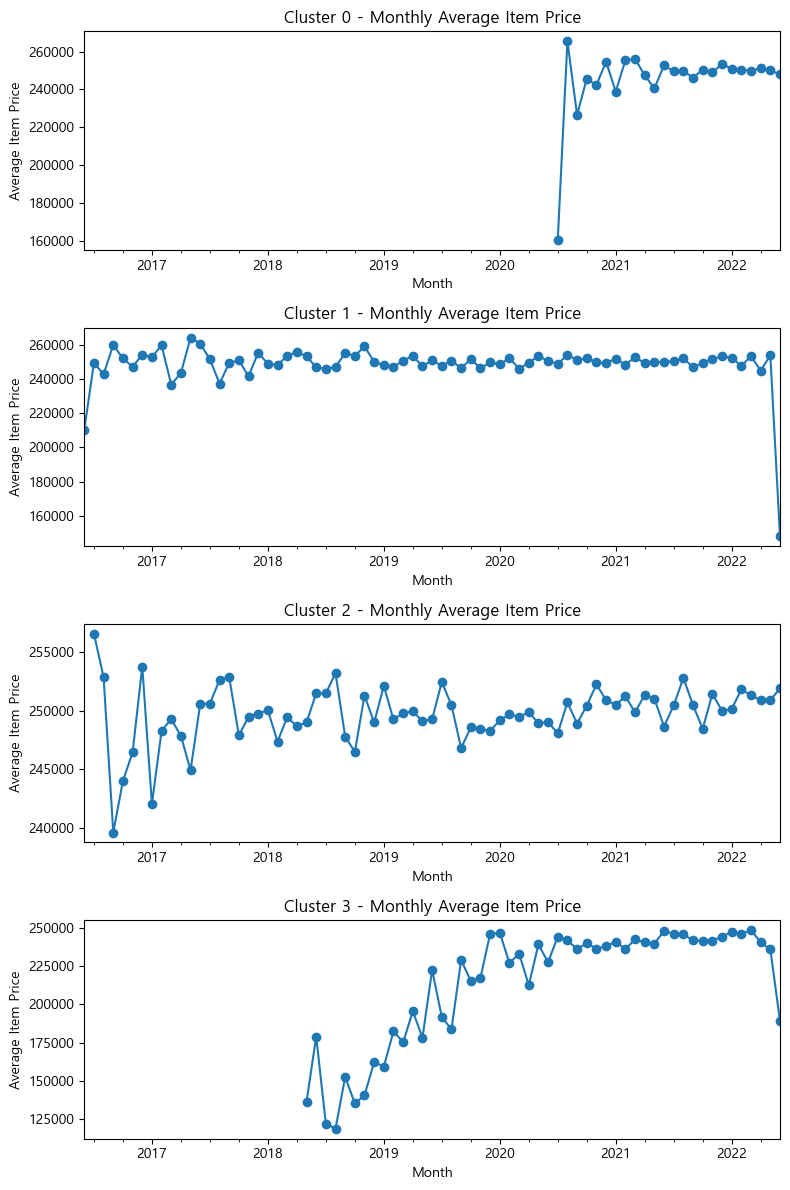

In [114]:
# 클러스터와 year_month로 그룹화하여 item_price의 평균을 계산합니다.
monthly_avg_prices = target.groupby(['Cluster', 'order_month'])['item_price'].mean().unstack().transpose()

clusters = sorted(target['Cluster'].unique())
fig, axes = plt.subplots(len(clusters), 1, figsize=(8, 3 * len(clusters)))

for i, cluster in enumerate(clusters):
    monthly_avg_prices[cluster].plot(ax=axes[i], marker='o')
    axes[i].set_title(f"Cluster {cluster} - Monthly Average Item Price")
    axes[i].set_ylabel("Average Item Price")
    axes[i].set_xlabel("Month")

plt.tight_layout()
plt.show()

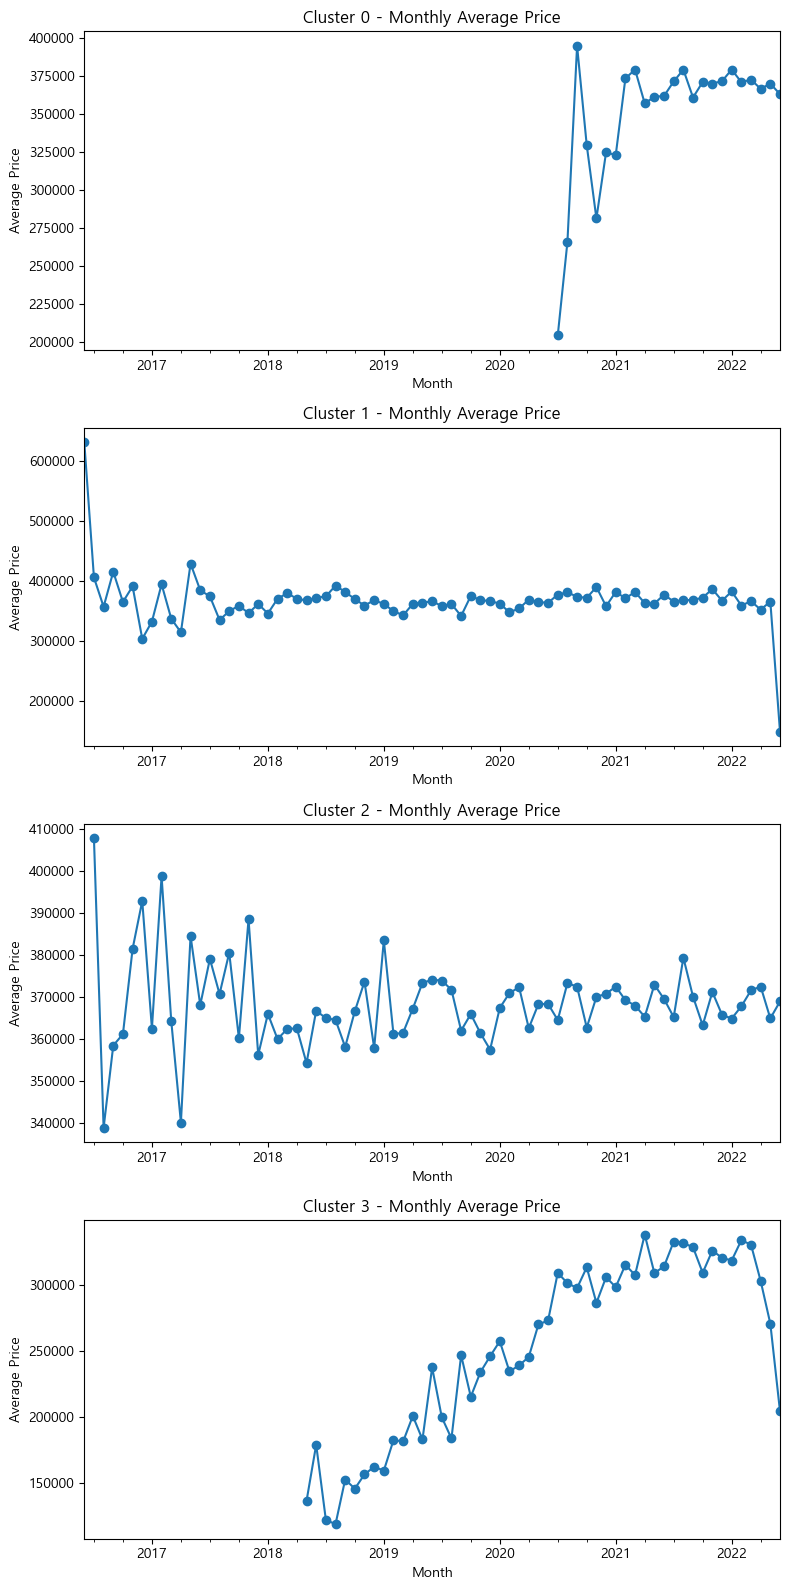

In [115]:
# 클러스터와 year_month로 그룹화하여 price의 평균을 계산합니다.
monthly_avg_prices = target.groupby(['Cluster', 'order_month'])['price'].mean().unstack().transpose()

clusters = sorted(target['Cluster'].unique())
fig, axes = plt.subplots(len(clusters), 1, figsize=(8, 4 * len(clusters)))

for i, cluster in enumerate(clusters):
    monthly_avg_prices[cluster].plot(ax=axes[i], marker='o')
    axes[i].set_title(f"Cluster {cluster} - Monthly Average Price")
    axes[i].set_ylabel("Average Price")
    axes[i].set_xlabel("Month")

plt.tight_layout()
plt.show()

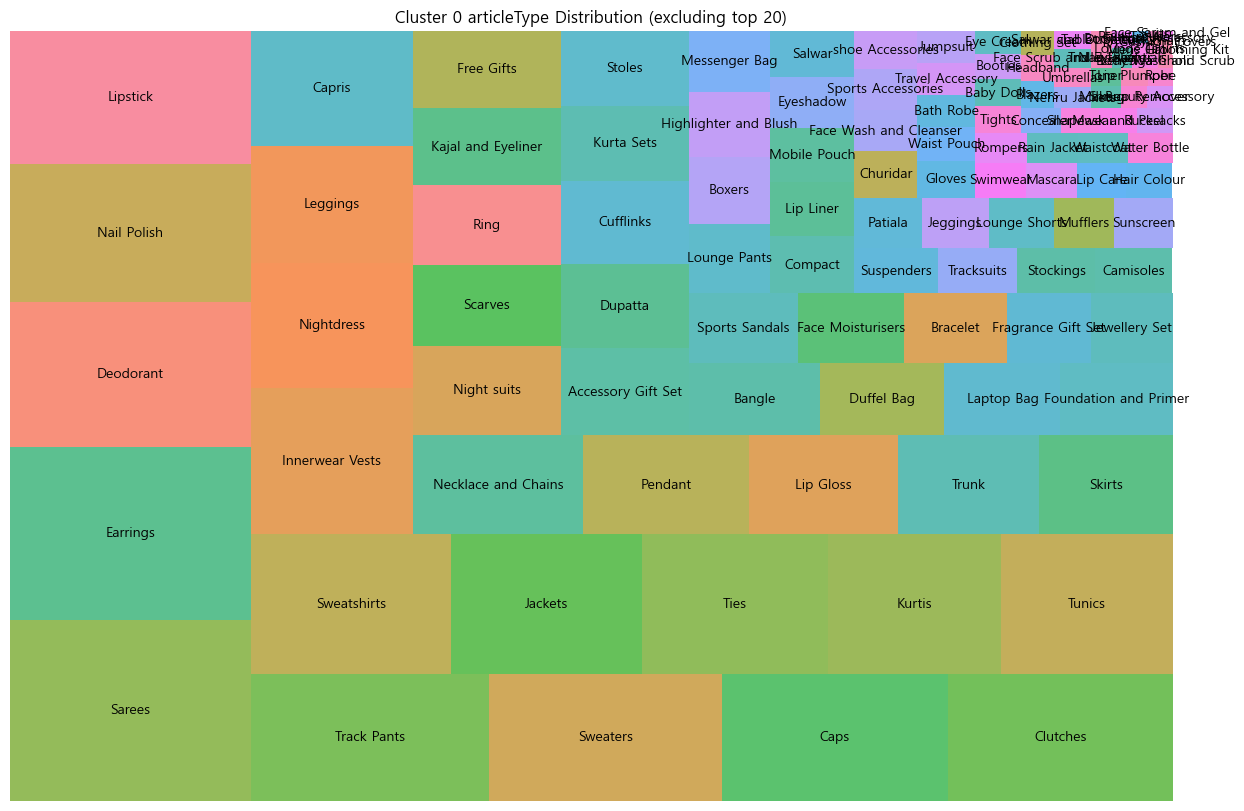

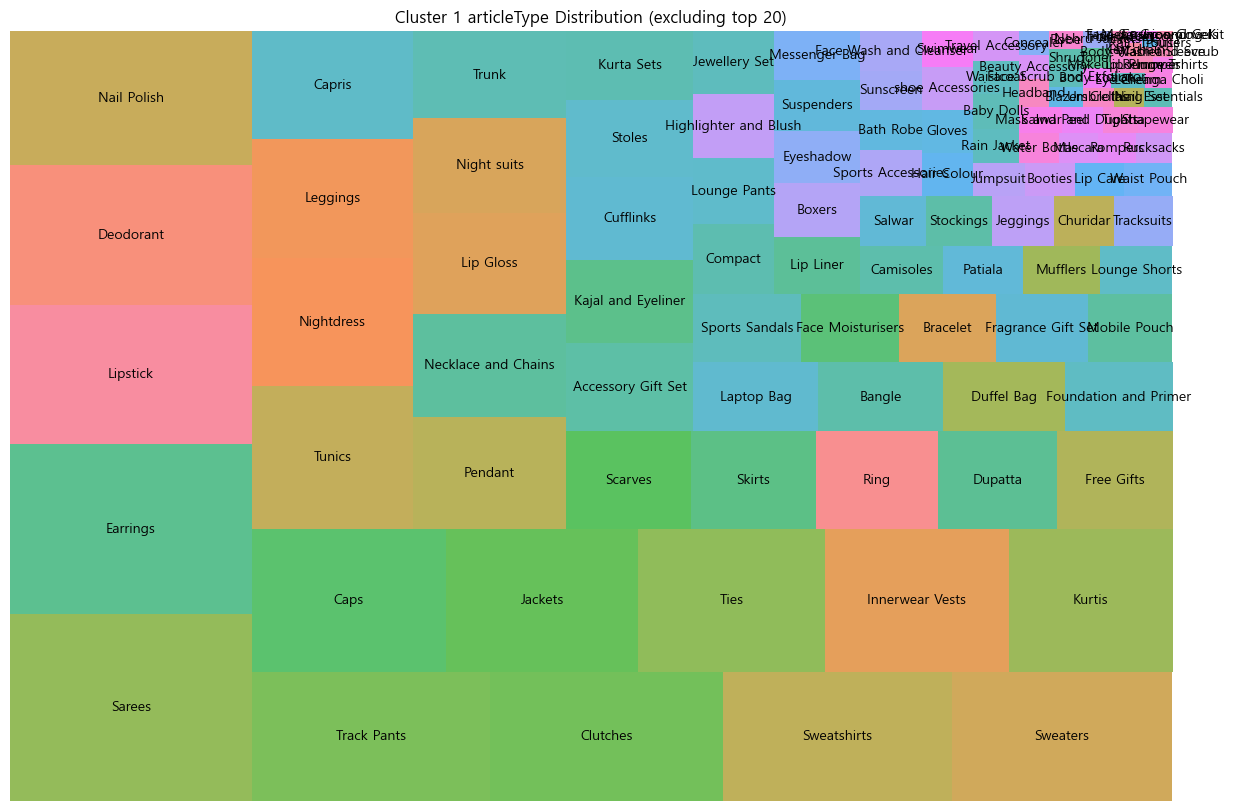

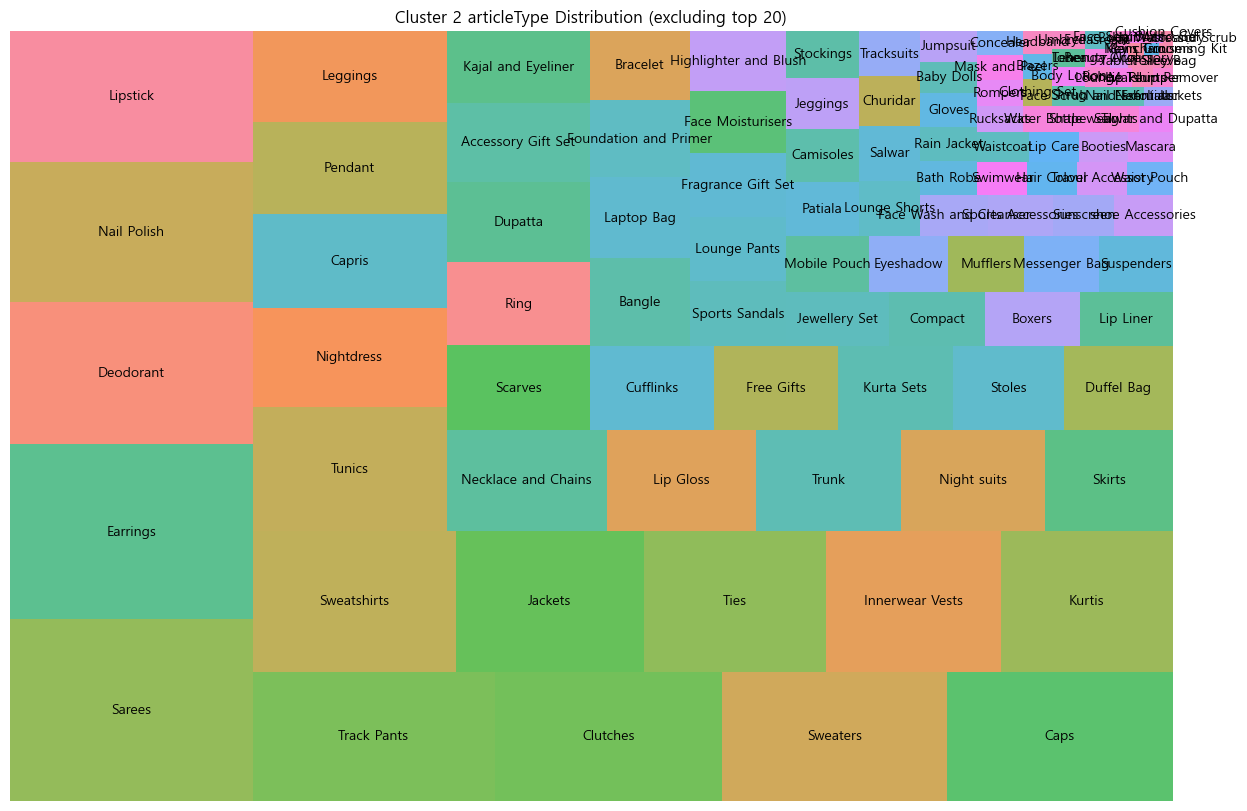

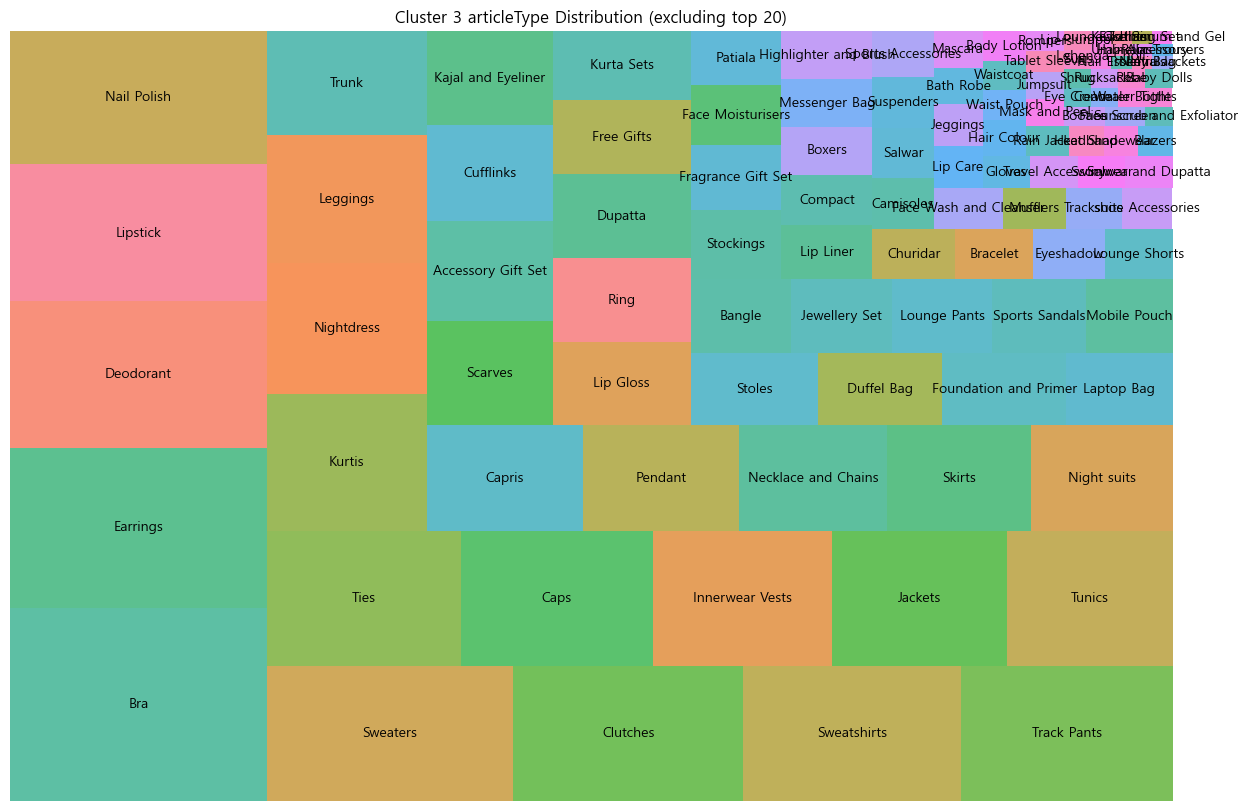

In [116]:
import squarify

# 클러스터별로 subCategory 구매 빈도 계산
cluster_subcat_counts = target.groupby('Cluster')['articleType'].value_counts()

# subCategory별로 고유한 색상을 지정합니다.
unique_subcategories = target['articleType'].unique()
palette = sns.color_palette('husl', len(unique_subcategories))
color_map = {subcat: palette[i] for i, subcat in enumerate(unique_subcategories)}

# 클러스터별로 데이터를 반복하며 트리맵 그리기
for cluster in cluster_subcat_counts.index.levels[0]:
    plt.figure(figsize=(15, 10))
    
    # 상위 10개 subCategory를 제외
    cluster_data = cluster_subcat_counts[cluster].iloc[25:]
    
    # 각 subCategory에 해당하는 색상을 가져옵니다.
    colors = [color_map[subcat] for subcat in cluster_data.index]
    
    squarify.plot(sizes=cluster_data.values, label=cluster_data.index, alpha=0.8, color=colors)
    plt.title(f'Cluster {cluster} articleType Distribution (excluding top 20)')
    plt.axis('off')
    plt.show()

In [117]:
# 클러스터별로 'Ethnic' 값의 수를 계산합니다.
ethnic_counts = target[target['usage'] == 'Ethnic'].groupby('Cluster').size()

# 각 클러스터에 대한 전체 행의 수를 계산합니다.
total_counts = target.groupby('Cluster').size()

# 두 값을 나누어 클러스터별 'Ethnic' 비율을 계산합니다.
ethnic_ratio = (ethnic_counts / total_counts * 100).fillna(0)

print(ethnic_ratio)

Cluster
0    7.236793
1    7.206559
2    7.275470
3    7.334096
dtype: float64


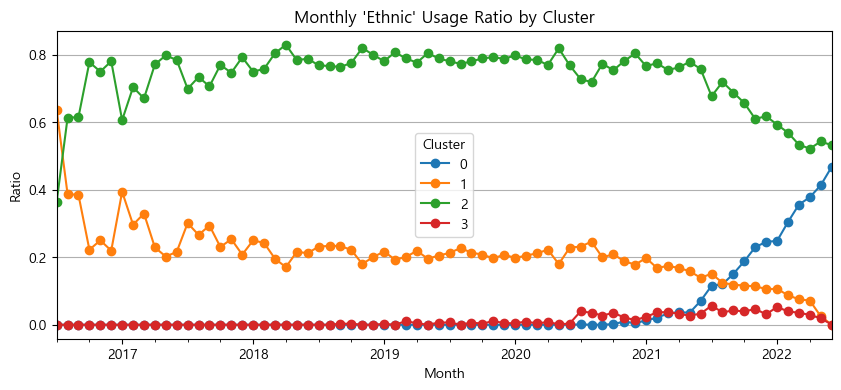

In [118]:
# 'Ethnic' 값인 행만 필터링합니다.
ethnic_df = target[target['usage'] == 'Ethnic']

# order_date에서 월 정보를 추출하여 새로운 컬럼 'month'를 생성합니다.
ethnic_df['month'] = ethnic_df['order_date'].dt.to_period('M')

# 월별로 전체 구매량을 계산합니다.
total_monthly_counts = ethnic_df.groupby('month').size()

# 월과 클러스터별로 구매량을 계산합니다.
cluster_monthly_counts = ethnic_df.groupby(['month', 'Cluster']).size().unstack(fill_value=0)

# 월별로 각 클러스터의 구매량을 전체 구매량으로 나누어 비율을 계산합니다.
cluster_monthly_ratios = cluster_monthly_counts.divide(total_monthly_counts, axis=0)

# 선 그래프로 비율을 시각화합니다.
cluster_monthly_ratios.plot(kind='line', marker='o', figsize=(10, 4))
plt.title("Monthly 'Ethnic' Usage Ratio by Cluster")
plt.xlabel('Month')
plt.ylabel('Ratio')
plt.legend(title='Cluster')
plt.grid(True, axis='y')
plt.show()

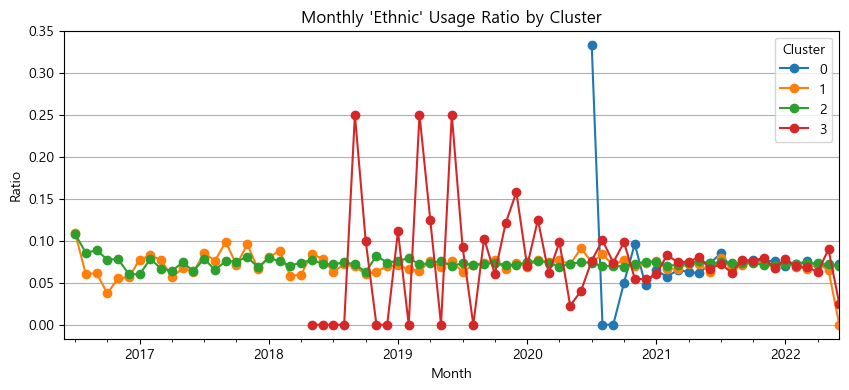

In [119]:
# 'Ethnic' 값인 행만 필터링합니다.
ethnic_df = target[target['usage'] == 'Ethnic']

# order_date에서 월 정보를 추출하여 새로운 컬럼 'month'를 생성합니다.
ethnic_df['month'] = ethnic_df['order_date'].dt.to_period('M')
# target['month'] = target['order_date'].dt.to_period('M')

# 'Ethnic'의 월별, 클러스터별 구매량을 계산합니다.
ethnic_cluster_monthly_counts = ethnic_df.groupby(['month', 'Cluster']).size().unstack(fill_value=0)

# 전체의 월별, 클러스터별 구매량을 계산합니다.
total_cluster_monthly_counts = target.groupby(['order_month', 'Cluster']).size().unstack(fill_value=0)

# 월별, 클러스터별 'Ethnic'의 비중을 계산합니다.
ethnic_cluster_monthly_ratios = ethnic_cluster_monthly_counts.divide(total_cluster_monthly_counts, axis=0)

# 선 그래프로 비중을 시각화합니다.
ethnic_cluster_monthly_ratios.plot(kind='line', marker='o', figsize=(10, 4))
plt.title("Monthly 'Ethnic' Usage Ratio by Cluster")
plt.xlabel('Month')
plt.ylabel('Ratio')
plt.legend(title='Cluster')
plt.grid(True, axis='y')
plt.show()

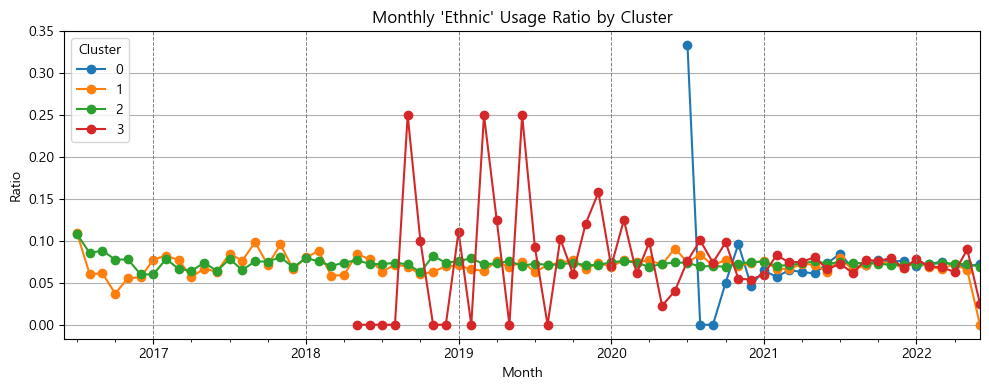

In [120]:
ethnic_df = target[target['usage'] == 'Ethnic']
ethnic_df['month'] = ethnic_df['order_date'].dt.to_period('M')

# 'Ethnic'의 월별, 클러스터별 구매량을 계산합니다.
ethnic_cluster_monthly_counts = ethnic_df.groupby(['month', 'Cluster']).size().unstack(fill_value=0)

# 전체의 월별, 클러스터별 구매량을 계산합니다.
total_cluster_monthly_counts = target.groupby(['order_month', 'Cluster']).size().unstack(fill_value=0)

# 월별, 클러스터별 'Ethnic'의 비중을 계산합니다.
ethnic_cluster_monthly_ratios = ethnic_cluster_monthly_counts.divide(total_cluster_monthly_counts, axis=0)


ax = ethnic_cluster_monthly_ratios.plot(kind='line', marker='o', figsize=(10, 4))

for period in ethnic_cluster_monthly_ratios.index:
    if period.month == 1:
        ax.axvline(x=period.strftime('%Y-%m'), color='gray', linestyle='--', lw=0.7)

plt.title("Monthly 'Ethnic' Usage Ratio by Cluster")
plt.xlabel('Month')
plt.ylabel('Ratio')
plt.legend(title='Cluster')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

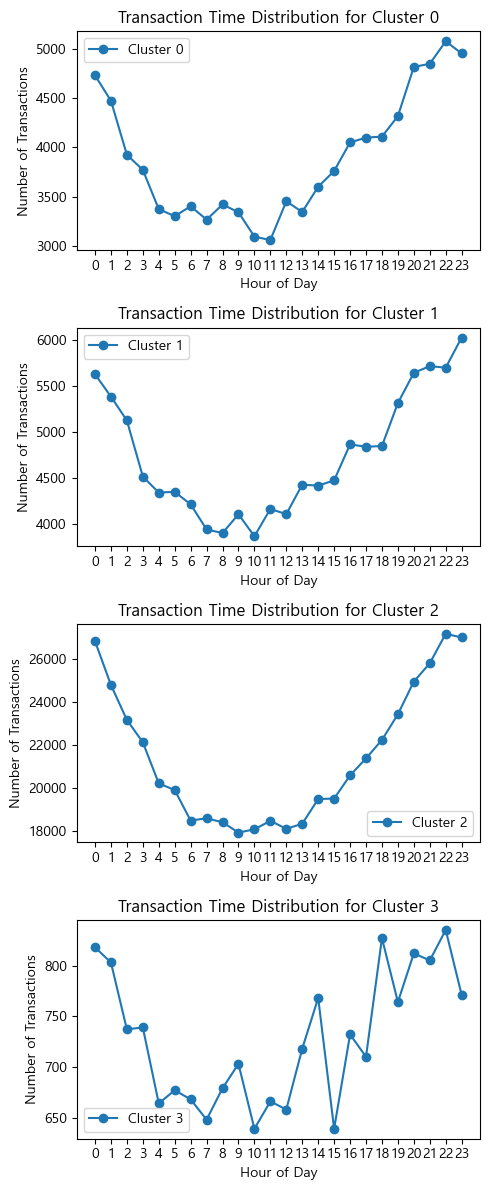

In [121]:
# 클러스터와 order_hour에 따라 거래 횟수를 집계
hourly_counts = target.groupby(['Cluster', 'order_hour'])['session_id'].count().reset_index()

clusters = sorted(target['Cluster'].unique())
# 클러스터의 수를 확인
num_clusters = len(clusters)

# 각 클러스터별로 subplot으로 그래프 생성
fig, axes = plt.subplots(nrows=num_clusters, figsize=(5, 3*num_clusters))

for idx, cluster in enumerate(clusters):
    cluster_data = hourly_counts[hourly_counts['Cluster'] == cluster]
    
    # 현재 subplot 선택
    ax = axes[idx]
    ax.plot(cluster_data['order_hour'], cluster_data['session_id'], label=f'Cluster {cluster}', marker='o')
    ax.set_title(f"Transaction Time Distribution for Cluster {cluster}")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Number of Transactions")
    ax.set_xticks(range(0, 24))
    ax.legend()

plt.tight_layout()
plt.show()

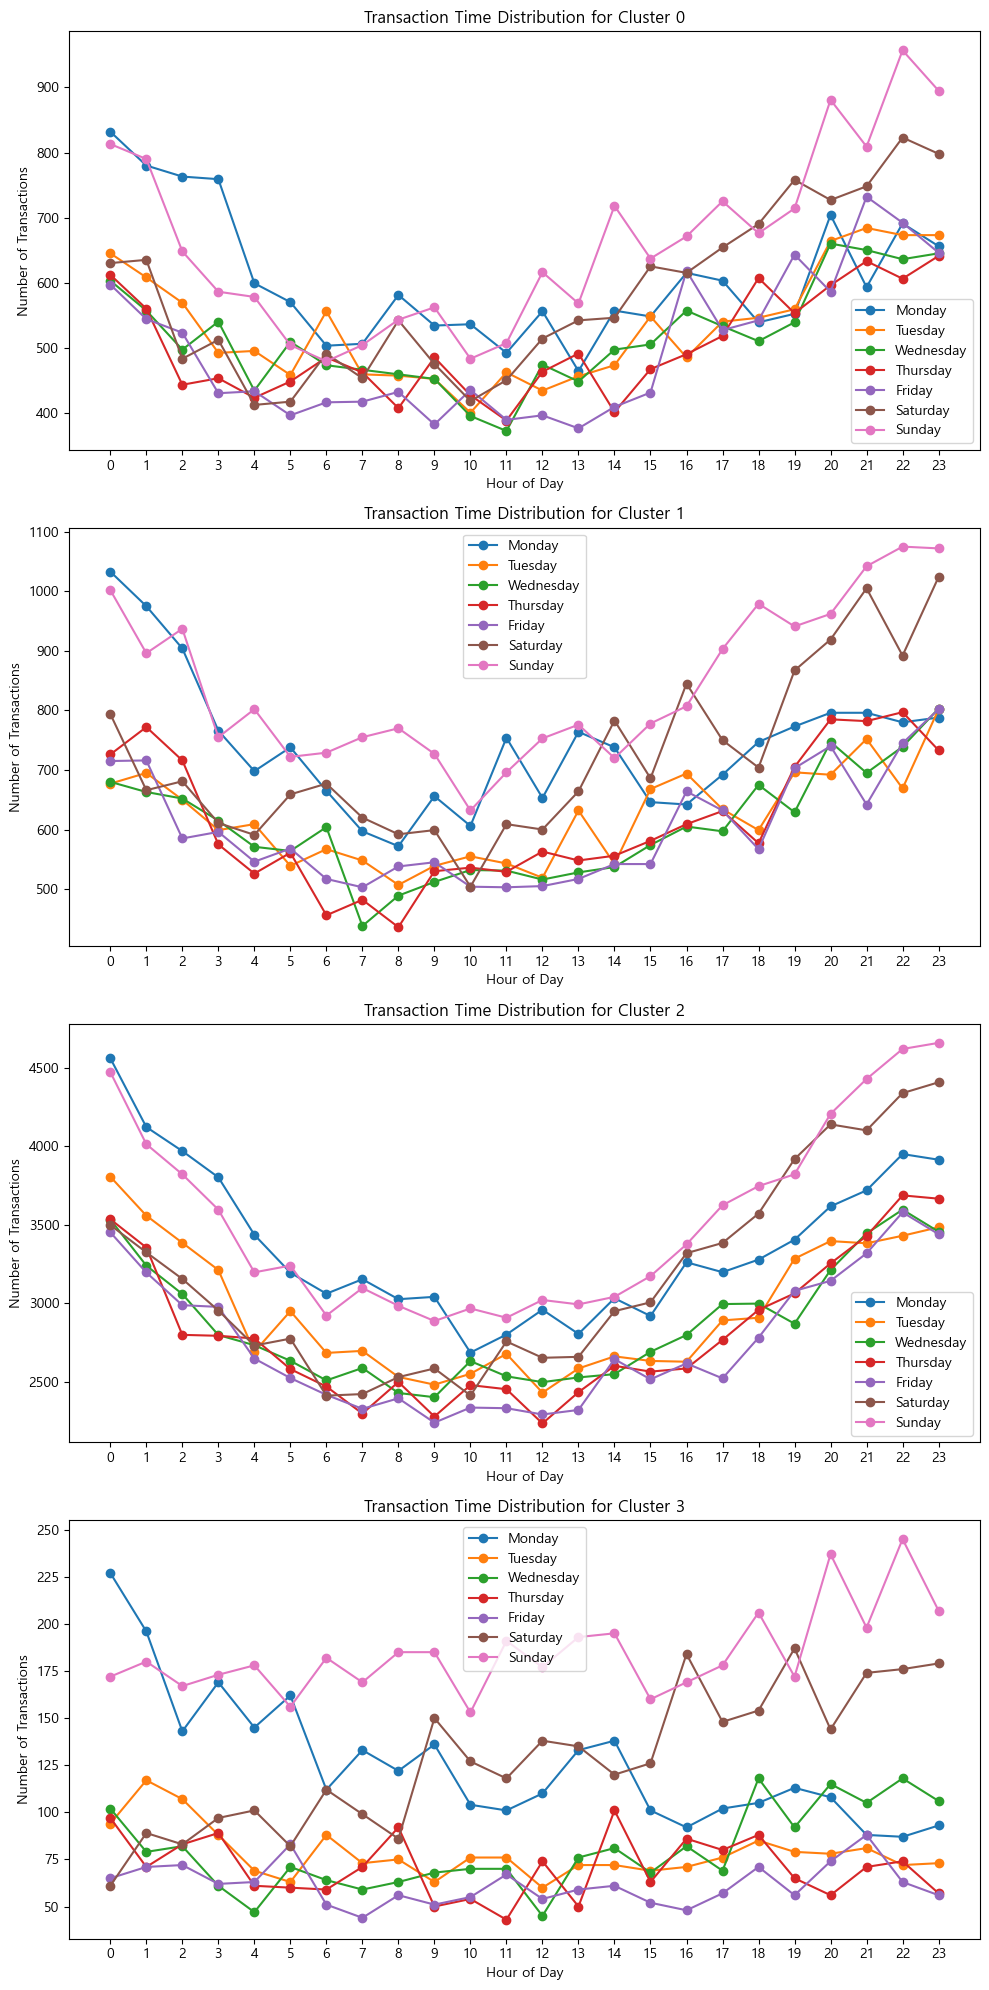

In [122]:
# order_date에서 요일 정보를 추출하여 새로운 컬럼 'weekday'를 생성합니다.
target['weekday'] = target['order_date'].dt.day_name()

# 요일 순서 지정 (월요일부터 시작)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 요일과 시간대, 클러스터별로 세션 수 계산
hourly_weekday_counts = target.groupby(['weekday', 'order_hour', 'Cluster']).size().reset_index(name='session_count')

# 클러스터별로 시각화
clusters = sorted(target['Cluster'].unique())
num_clusters = len(clusters)

fig, axes = plt.subplots(nrows=num_clusters, figsize=(10, 5*num_clusters))

for idx, cluster in enumerate(clusters):
    ax = axes[idx]
    
    for day in days_order:
        daily_data = hourly_weekday_counts[(hourly_weekday_counts['Cluster'] == cluster) & (hourly_weekday_counts['weekday'] == day)]
        ax.plot(daily_data['order_hour'], daily_data['session_count'], label=day, marker='o')
    
    ax.set_title(f"Transaction Time Distribution for Cluster {cluster}")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Number of Transactions")
    ax.set_xticks(range(0, 24))
    ax.legend()

plt.tight_layout()
plt.show()

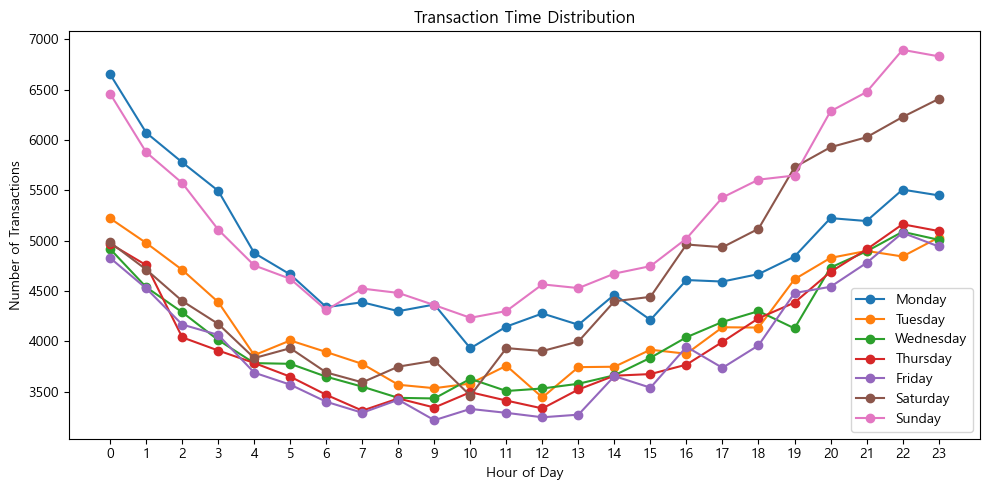

In [123]:
# order_date에서 요일 정보를 추출하여 새로운 컬럼 'weekday'를 생성합니다.
target['weekday'] = target['order_date'].dt.day_name()

# 요일 순서 지정 (월요일부터 시작)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 요일과 시간대별로 세션 수 계산
hourly_weekday_counts = target.groupby(['weekday', 'order_hour']).size().reset_index(name='session_count')

# 시각화
fig, ax = plt.subplots(figsize=(10, 5))

for day in days_order:
    daily_data = hourly_weekday_counts[hourly_weekday_counts['weekday'] == day]
    ax.plot(daily_data['order_hour'], daily_data['session_count'], label=day, marker='o')

ax.set_title("Transaction Time Distribution")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Number of Transactions")
ax.set_xticks(range(0, 24))
ax.legend()

plt.tight_layout()
plt.show()

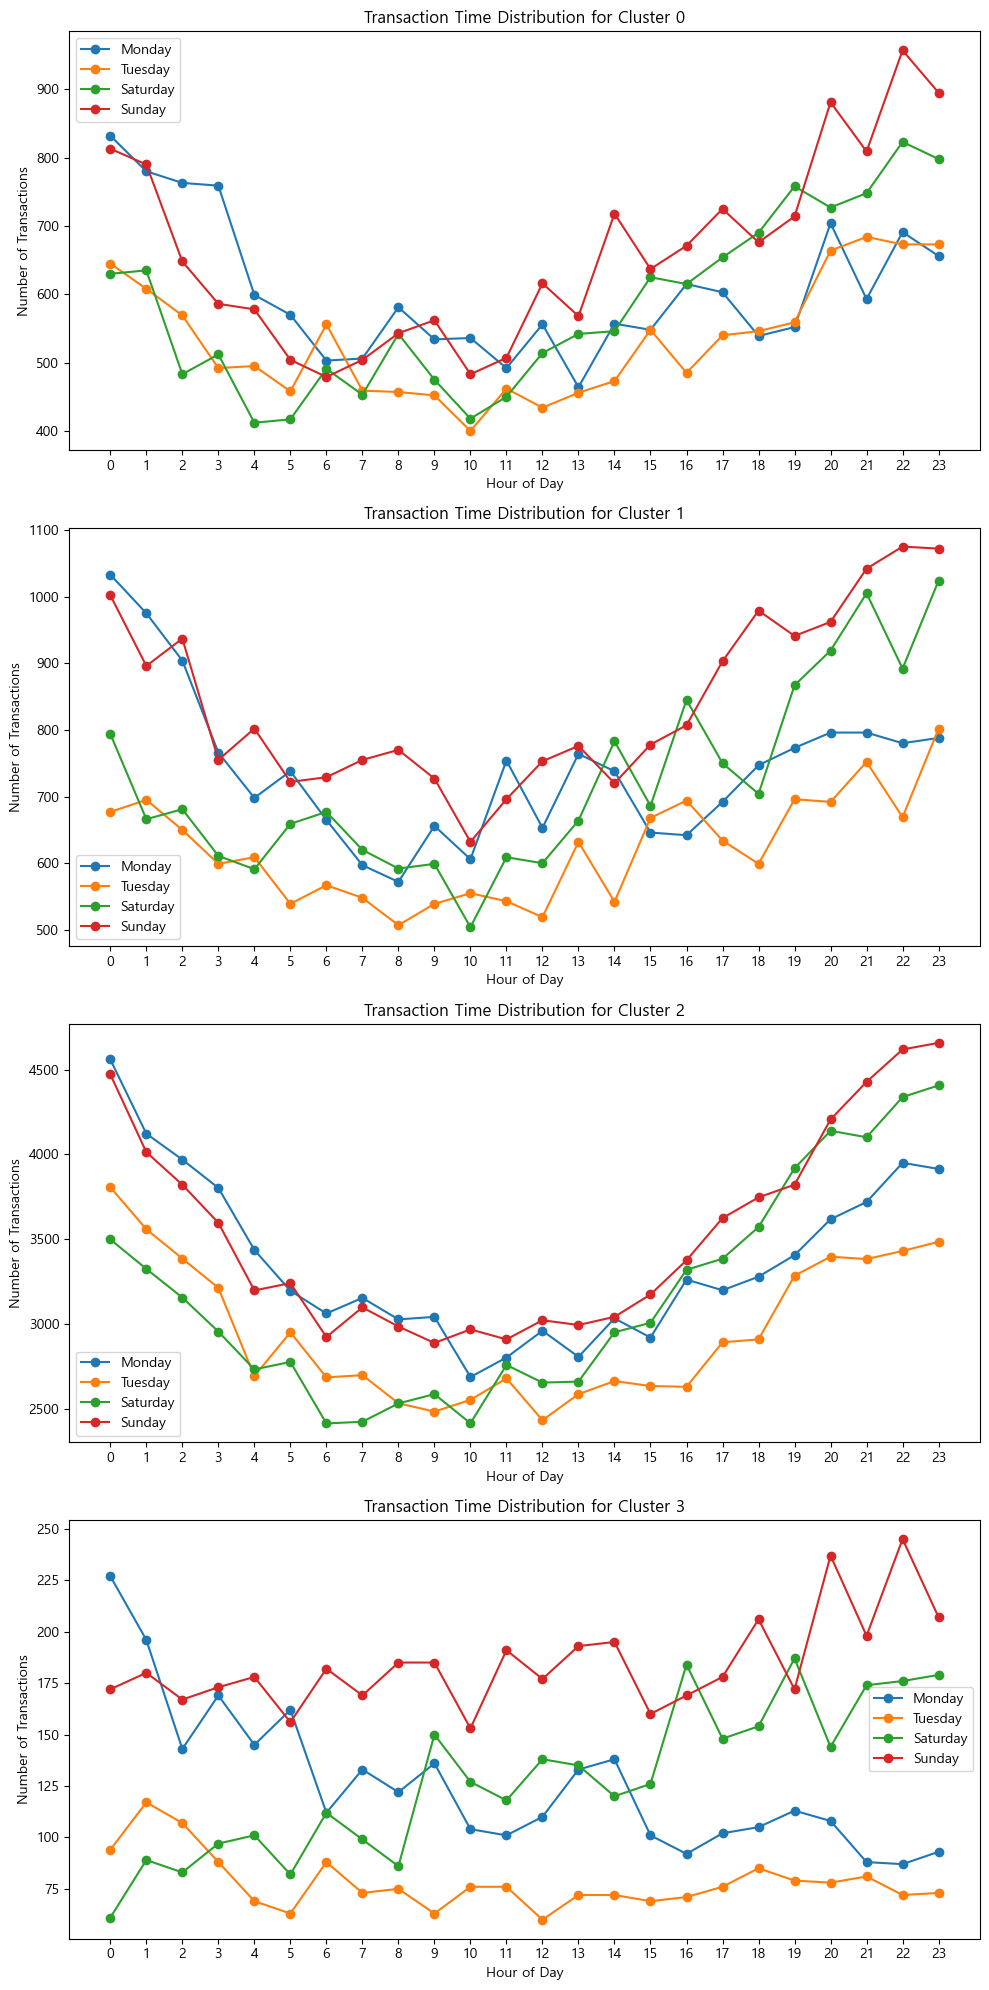

In [124]:
# order_date에서 요일 정보를 추출하여 새로운 컬럼 'weekday'를 생성합니다.
target['weekday'] = target['order_date'].dt.day_name()

# 요일 순서 지정 (월요일부터 시작)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 요일과 시간대, 클러스터별로 세션 수 계산
hourly_weekday_counts = target.groupby(['weekday', 'order_hour', 'Cluster']).size().reset_index(name='session_count')

# 선택할 요일 지정
selected_days = ['Monday', 'Tuesday', 'Saturday', 'Sunday']

# 선택된 요일에 해당하는 데이터만 필터링
filtered_data = hourly_weekday_counts[hourly_weekday_counts['weekday'].isin(selected_days)]

# 클러스터별로 시각화
clusters = sorted(target['Cluster'].unique())
num_clusters = len(clusters)

fig, axes = plt.subplots(nrows=num_clusters, figsize=(10, 5*num_clusters))

for idx, cluster in enumerate(clusters):
    ax = axes[idx]
    
    for day in selected_days:
        daily_data = filtered_data[(filtered_data['Cluster'] == cluster) & (filtered_data['weekday'] == day)]
        ax.plot(daily_data['order_hour'], daily_data['session_count'], label=day, marker='o')
    
    ax.set_title(f"Transaction Time Distribution for Cluster {cluster}")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Number of Transactions")
    ax.set_xticks(range(0, 24))
    ax.legend()

plt.tight_layout()
plt.show()

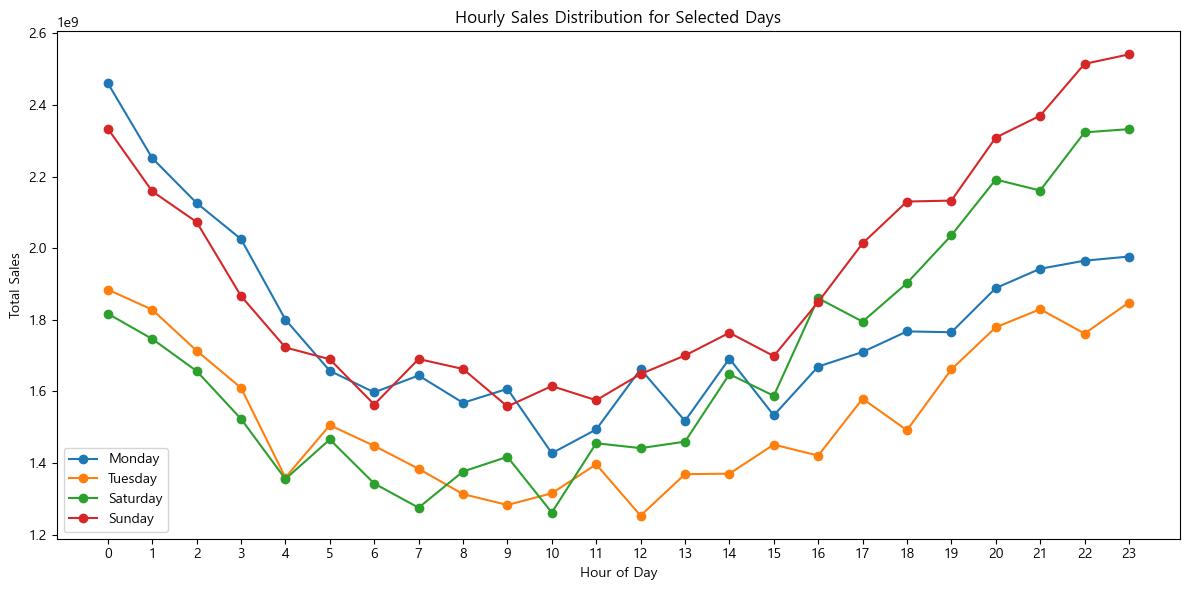

In [125]:
# 시간대별로 거래금액 차이나는지도 보고싶다. 
# 선택할 요일 지정
selected_days = ['Monday', 'Tuesday', 'Saturday', 'Sunday']

# 요일과 시간대별로 price의 합을 계산
hourly_weekday_sales = target.groupby(['weekday', 'order_hour'])['price'].sum().reset_index()

# 선택된 요일에 해당하는 데이터만 필터링
filtered_sales = hourly_weekday_sales[hourly_weekday_sales['weekday'].isin(selected_days)]

fig, ax = plt.subplots(figsize=(12, 6))

for day in selected_days:
    daily_sales = filtered_sales[filtered_sales['weekday'] == day]
    ax.plot(daily_sales['order_hour'], daily_sales['price'], label=day, marker='o')
    
ax.set_title(f"Hourly Sales Distribution for Selected Days")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Total Sales")
ax.set_xticks(range(0, 24))
ax.legend()

plt.tight_layout()
plt.show()

언제부터 이탈이 낮아진다를. 2번대상으로 봐봐야겠다. order_num 별 이용고객수 얼마나 줄어드는지.....비율보면 되나...?

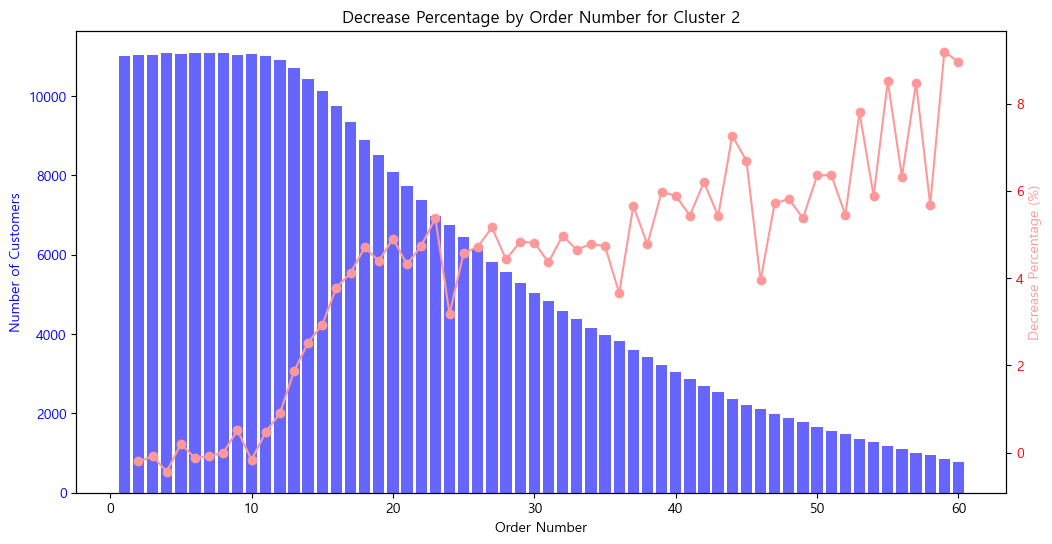

In [126]:
# Cluster가 2이고, order_num이 60 이하인 데이터만 필터링합니다.
cluster2_data = target[(target['Cluster'] == 2) & (target['order_num'] <= 60)]

# order_num 별로 unique한 고객 수를 계산합니다.
customer_counts = cluster2_data.groupby('order_num')['customer_id'].nunique()

# order_num 별로 이전 대비 고객 수 감소 비율을 계산합니다.
decrease_percentage = (customer_counts.shift(1) - customer_counts) / customer_counts.shift(1) * 100

fig, ax1 = plt.subplots(figsize=(12, 6))

# 고객 수를 막대 그래프로 표시합니다.
ax1.bar(customer_counts.index, customer_counts.values, alpha=0.6, label='Number of Customers', color='blue')
ax1.set_xlabel('Order Number')
ax1.set_ylabel('Number of Customers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # 두 번째 y축을 ax1과 공유
# 고객 수 감소 비율을 선 그래프로 표시합니다.
ax2.plot(decrease_percentage.index, decrease_percentage.values, marker='o', label='Decrease Percentage', color='#ff9999')
ax2.set_ylabel('Decrease Percentage (%)', color='#ff9999')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Decrease Percentage by Order Number for Cluster 2')
plt.show()

In [127]:
cluster2_data10 = target[(target['Cluster'] == 2) & (target['order_num'].isin([1, 10]))]

# 각 customer_id에 대해 order_num이 18일 때와 1일 때의 order_date의 차이를 계산합니다.
def calculate_duration(group):
    if 1 in group['order_num'].values and 10 in group['order_num'].values:
        date_1 = group[group['order_num'] == 1]['order_date'].values[0]
        date_10 = group[group['order_num'] == 10]['order_date'].values[0]
        
        # numpy.timedelta64를 정수로 변환하여 일 수를 추출
        return int((date_10 - date_1) / np.timedelta64(1, 'D'))
    else:
        return None

durations10 = cluster2_data10.groupby('customer_id').apply(calculate_duration).dropna()

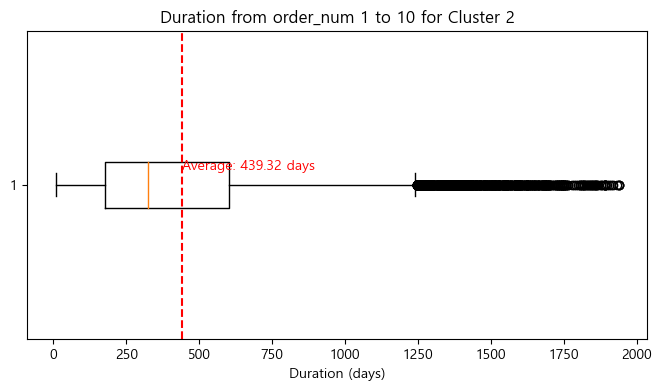

In [128]:
# 결과를 boxplot으로 시각화합니다.
plt.figure(figsize=(8, 4))
plt.boxplot(durations, vert=False)
plt.xlabel('Duration (days)')
plt.title('Duration from order_num 1 to 10 for Cluster 2')

# 평균 값을 표시합니다.
avg_duration = durations.mean()
plt.axvline(x=avg_duration, color='r', linestyle='--')
plt.text(avg_duration+0.5, 1.05, f'Average: {avg_duration:.2f} days', color='red')

plt.show()

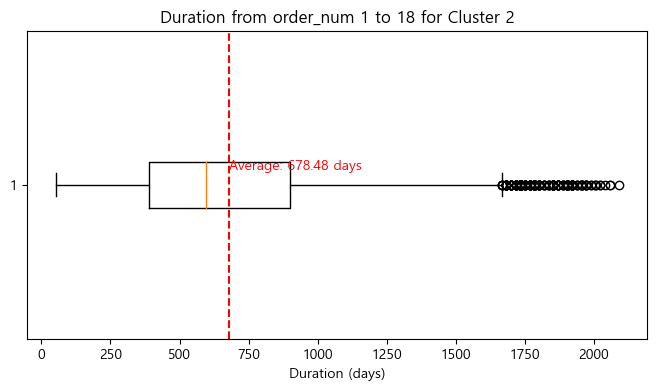

In [129]:
cluster2_data = target[(target['Cluster'] == 2) & (target['order_num'].isin([1, 18]))]

# 각 customer_id에 대해 order_num이 18일 때와 1일 때의 order_date의 차이를 계산합니다.
def calculate_duration(group):
    if 1 in group['order_num'].values and 18 in group['order_num'].values:
        date_1 = group[group['order_num'] == 1]['order_date'].values[0]
        date_18 = group[group['order_num'] == 18]['order_date'].values[0]
        
        # numpy.timedelta64를 정수로 변환하여 일 수를 추출
        return int((date_18 - date_1) / np.timedelta64(1, 'D'))
    else:
        return None

durations = cluster2_data.groupby('customer_id').apply(calculate_duration).dropna()

# 결과를 boxplot으로 시각화합니다.
plt.figure(figsize=(8, 4))
plt.boxplot(durations, vert=False)
plt.xlabel('Duration (days)')
plt.title('Duration from order_num 1 to 18 for Cluster 2')

# 평균 값을 표시합니다.
avg_duration = durations.mean()
plt.axvline(x=avg_duration, color='r', linestyle='--')
plt.text(avg_duration+0.5, 1.05, f'Average: {avg_duration:.2f} days', color='red')

plt.show()

ㅋㅋㅋㅋㅋㅋㅋ678을 이용하면 나라도 계속쓰겠다.....

In [130]:
# 각 고객별 첫 구매 날짜를 계산합니다.
first_purchase_date = target.groupby('customer_id')['order_date'].min().reset_index(name='first_purchase_date')

# 첫 구매 날짜를 기반으로 target 데이터에 병합합니다.
target_merged = target.merge(first_purchase_date, on='customer_id')

# 첫 구매로부터 3개월 이내의 데이터만 선택합니다.
three_months_data = target_merged[target_merged['order_date'] <= target_merged['first_purchase_date'] + pd.Timedelta(weeks=12)]

# 클러스터와 고객별로 session_id의 개수 (즉, 구매 횟수)를 계산합니다.
purchase_counts = three_months_data.groupby(['Cluster', 'customer_id'])['session_id'].nunique().reset_index(name='purchase_count')

# 각 클러스터의 평균 구매 횟수를 계산합니다.
avg_purchases = purchase_counts.groupby('Cluster')['purchase_count'].mean().reset_index()

print(avg_purchases)


   Cluster  purchase_count
0        0        4.108618
1        1        1.033798
2        2        3.185612
3        3        1.031320


In [131]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740041 entries, 0 to 740040
Data columns (total 39 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   created_at           740041 non-null  datetime64[ns, UTC]
 1   customer_id          740041 non-null  int64              
 2   session_id           740041 non-null  object             
 3   payment_method       740041 non-null  object             
 4   payment_status       740041 non-null  object             
 5   promo_amount         740041 non-null  int64              
 6   promo_code           740041 non-null  object             
 7   shipment_fee         740041 non-null  int64              
 8   product_id           740041 non-null  int64              
 9   quantity             740041 non-null  int64              
 10  item_price           740041 non-null  int64              
 11  buy_age              740041 non-null  int64              
 12  fi